# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60.0K/60.0K [01:03<00:00, 945File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

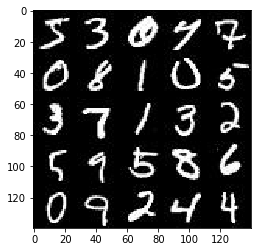

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

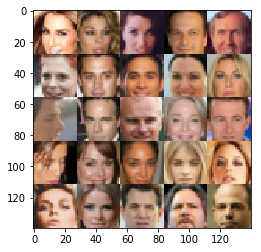

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
   
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name= 'input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[])

    return real_inputs, inputs_z, learning_rate


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [42]:
def discriminator(images, reuse=False):
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='SAME')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [59]:
def generator(z, out_channel_dim, is_train=True):
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 3*3*1024)
        
        x1 = tf.reshape(x1, (-1, 3, 3, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x1024 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x128 now
        
        x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


tests.test_generator(generator, tf)

(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 5)
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim):
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


tests.test_model_loss(model_loss)

(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [61]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [62]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [71]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps %10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 1)
Epoch 1/10... Discriminator Loss: 0.2599... Generator Loss: 9.8155
Epoch 1/10... Discriminator Loss: 1.7709... Generator Loss: 1.1506
Epoch 1/10... Discriminator Loss: 2.3531... Generator Loss: 0.1955
Epoch 1/10... Discriminator Loss: 1.6144... Generator Loss: 0.4985
Epoch 1/10... Discriminator Loss: 0.8710... Generator Loss: 2.2470
Epoch 1/10... Discriminator Loss: 0.7904... Generator Loss: 1.0609
Epoch 1/10... Discriminator Loss: 1.5823... Generator Loss: 0.5070
Epoch 1/10... Discriminator Loss: 1.0793... Generator Loss: 1.3006
Epoch 1/10... Discriminator Loss: 1.7634... Generator Loss: 1.0269
Epoch 1/10... Discriminator Loss: 1.1784... Generator Loss: 0.6754
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 1)


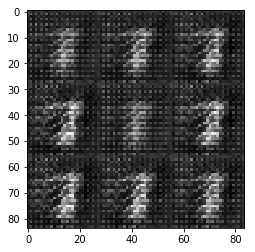

Epoch 1/10... Discriminator Loss: 1.6669... Generator Loss: 0.7225
Epoch 1/10... Discriminator Loss: 1.2689... Generator Loss: 0.7083
Epoch 1/10... Discriminator Loss: 1.6089... Generator Loss: 0.8252
Epoch 1/10... Discriminator Loss: 1.2016... Generator Loss: 0.7546
Epoch 1/10... Discriminator Loss: 1.3160... Generator Loss: 0.6380
Epoch 1/10... Discriminator Loss: 1.8056... Generator Loss: 0.4935
Epoch 1/10... Discriminator Loss: 1.3694... Generator Loss: 0.6650
Epoch 1/10... Discriminator Loss: 1.5434... Generator Loss: 0.6233
Epoch 1/10... Discriminator Loss: 1.4147... Generator Loss: 0.6400
Epoch 1/10... Discriminator Loss: 1.4285... Generator Loss: 0.5241
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 1)


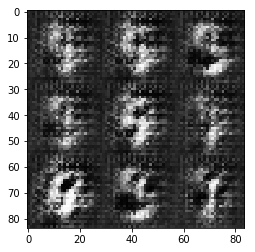

Epoch 1/10... Discriminator Loss: 1.6565... Generator Loss: 0.5630
Epoch 1/10... Discriminator Loss: 1.4536... Generator Loss: 0.5517
Epoch 1/10... Discriminator Loss: 1.3387... Generator Loss: 0.6557
Epoch 1/10... Discriminator Loss: 1.6961... Generator Loss: 0.3634
Epoch 1/10... Discriminator Loss: 1.2862... Generator Loss: 1.7301
Epoch 1/10... Discriminator Loss: 1.3785... Generator Loss: 0.7605
Epoch 1/10... Discriminator Loss: 1.5872... Generator Loss: 0.4189
Epoch 1/10... Discriminator Loss: 1.6896... Generator Loss: 0.2721
Epoch 1/10... Discriminator Loss: 1.3902... Generator Loss: 0.4916
Epoch 1/10... Discriminator Loss: 1.4645... Generator Loss: 0.3746
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 1)


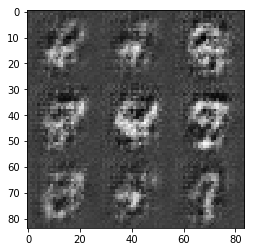

Epoch 1/10... Discriminator Loss: 1.5572... Generator Loss: 0.3026
Epoch 1/10... Discriminator Loss: 1.4111... Generator Loss: 1.2051
Epoch 1/10... Discriminator Loss: 1.7209... Generator Loss: 0.2913
Epoch 1/10... Discriminator Loss: 1.1392... Generator Loss: 1.4754
Epoch 1/10... Discriminator Loss: 1.2158... Generator Loss: 0.8217
Epoch 1/10... Discriminator Loss: 1.3127... Generator Loss: 0.9014
Epoch 1/10... Discriminator Loss: 1.6891... Generator Loss: 0.2479
Epoch 1/10... Discriminator Loss: 1.0387... Generator Loss: 1.4057
Epoch 1/10... Discriminator Loss: 1.2673... Generator Loss: 0.5738
Epoch 1/10... Discriminator Loss: 1.6081... Generator Loss: 0.2719
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 1)


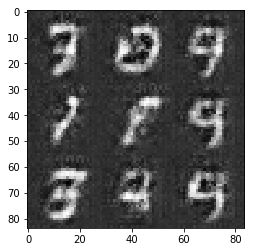

Epoch 1/10... Discriminator Loss: 1.1053... Generator Loss: 2.5390
Epoch 1/10... Discriminator Loss: 1.9373... Generator Loss: 0.1904
Epoch 1/10... Discriminator Loss: 1.2110... Generator Loss: 3.0748
Epoch 1/10... Discriminator Loss: 0.5047... Generator Loss: 1.7762
Epoch 1/10... Discriminator Loss: 0.8341... Generator Loss: 1.3647
Epoch 1/10... Discriminator Loss: 1.4588... Generator Loss: 0.3199
Time for previous epoch: 2862.95627617836
Time till previous epoch: 2881.5921397209167
Epoch 2/10... Discriminator Loss: 1.3549... Generator Loss: 0.4768
Epoch 2/10... Discriminator Loss: 0.8260... Generator Loss: 1.9995
Epoch 2/10... Discriminator Loss: 2.2387... Generator Loss: 0.1311
Epoch 2/10... Discriminator Loss: 1.4593... Generator Loss: 0.3233
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 1)


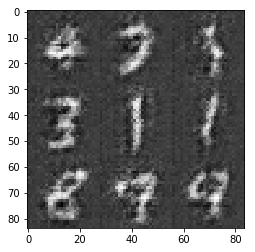

Epoch 2/10... Discriminator Loss: 1.9235... Generator Loss: 0.2000
Epoch 2/10... Discriminator Loss: 1.7519... Generator Loss: 0.2234
Epoch 2/10... Discriminator Loss: 0.7622... Generator Loss: 1.0832
Epoch 2/10... Discriminator Loss: 0.4073... Generator Loss: 2.8318
Epoch 2/10... Discriminator Loss: 0.9861... Generator Loss: 0.9999
Epoch 2/10... Discriminator Loss: 1.0326... Generator Loss: 0.6445
Epoch 2/10... Discriminator Loss: 1.3962... Generator Loss: 0.3613
Epoch 2/10... Discriminator Loss: 1.2169... Generator Loss: 0.4309
Epoch 2/10... Discriminator Loss: 1.4099... Generator Loss: 0.3584
Epoch 2/10... Discriminator Loss: 0.8164... Generator Loss: 0.8966
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 1)


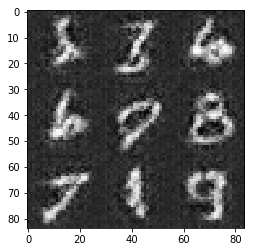

Epoch 2/10... Discriminator Loss: 1.7516... Generator Loss: 2.5835
Epoch 2/10... Discriminator Loss: 1.4367... Generator Loss: 0.3430
Epoch 2/10... Discriminator Loss: 1.1376... Generator Loss: 0.5786
Epoch 2/10... Discriminator Loss: 0.8632... Generator Loss: 0.8108
Epoch 2/10... Discriminator Loss: 0.6510... Generator Loss: 2.9640
Epoch 2/10... Discriminator Loss: 2.7514... Generator Loss: 0.0806
Epoch 2/10... Discriminator Loss: 1.3084... Generator Loss: 0.5497
Epoch 2/10... Discriminator Loss: 1.1996... Generator Loss: 0.5047
Epoch 2/10... Discriminator Loss: 1.0178... Generator Loss: 0.6748


KeyboardInterrupt: 

In [72]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 10    #trained till 2 epochs

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)
Epoch 1/20... Discriminator Loss: 2.6061... Generator Loss: 0.3153
Epoch 1/20... Discriminator Loss: 1.5561... Generator Loss: 1.1607
Epoch 1/20... Discriminator Loss: 1.3442... Generator Loss: 0.5707
Epoch 1/20... Discriminator Loss: 1.9566... Generator Loss: 0.5381
Epoch 1/20... Discriminator Loss: 1.7843... Generator Loss: 0.4586
Epoch 1/20... Discriminator Loss: 1.6314... Generator Loss: 0.5163
Epoch 1/20... Discriminator Loss: 1.4299... Generator Loss: 0.6952
Epoch 1/20... Discriminator Loss: 1.8215... Generator Loss: 0.4479
Epoch 1/20... Discriminator Loss: 1.7425... Generator Loss: 0.4722
Epoch 1/20... Discriminator Loss: 1.5939... Generator Loss: 0.5719
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


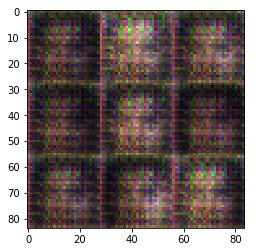

Epoch 1/20... Discriminator Loss: 1.6251... Generator Loss: 0.5890
Epoch 1/20... Discriminator Loss: 1.6630... Generator Loss: 0.5224
Epoch 1/20... Discriminator Loss: 1.5661... Generator Loss: 0.5804
Epoch 1/20... Discriminator Loss: 1.5481... Generator Loss: 0.5828
Epoch 1/20... Discriminator Loss: 1.6752... Generator Loss: 0.4194
Epoch 1/20... Discriminator Loss: 1.5840... Generator Loss: 0.5370
Epoch 1/20... Discriminator Loss: 1.4776... Generator Loss: 0.5891
Epoch 1/20... Discriminator Loss: 1.6494... Generator Loss: 0.4815
Epoch 1/20... Discriminator Loss: 1.5998... Generator Loss: 0.5679
Epoch 1/20... Discriminator Loss: 1.6956... Generator Loss: 0.5560
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


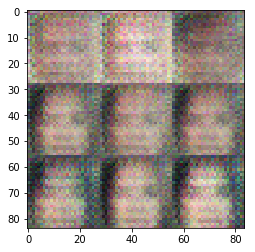

Epoch 1/20... Discriminator Loss: 1.4413... Generator Loss: 0.5870
Epoch 1/20... Discriminator Loss: 1.6031... Generator Loss: 0.5689
Epoch 1/20... Discriminator Loss: 1.4914... Generator Loss: 0.5830
Epoch 1/20... Discriminator Loss: 1.4644... Generator Loss: 0.6401
Epoch 1/20... Discriminator Loss: 1.5054... Generator Loss: 0.6221
Epoch 1/20... Discriminator Loss: 1.5001... Generator Loss: 0.6197
Epoch 1/20... Discriminator Loss: 1.6369... Generator Loss: 0.5597
Epoch 1/20... Discriminator Loss: 1.4238... Generator Loss: 0.6395
Epoch 1/20... Discriminator Loss: 1.4791... Generator Loss: 0.5994
Epoch 1/20... Discriminator Loss: 1.5150... Generator Loss: 0.5777
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


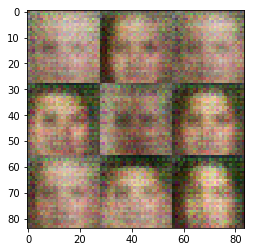

Epoch 1/20... Discriminator Loss: 1.5470... Generator Loss: 0.5238
Epoch 1/20... Discriminator Loss: 1.4546... Generator Loss: 0.6314
Epoch 1/20... Discriminator Loss: 1.5628... Generator Loss: 0.5592
Epoch 1/20... Discriminator Loss: 1.5534... Generator Loss: 0.5869
Epoch 1/20... Discriminator Loss: 1.5133... Generator Loss: 0.5738
Epoch 1/20... Discriminator Loss: 1.5217... Generator Loss: 0.5643
Epoch 1/20... Discriminator Loss: 1.5078... Generator Loss: 0.5717
Epoch 1/20... Discriminator Loss: 1.4383... Generator Loss: 0.6070
Epoch 1/20... Discriminator Loss: 1.4990... Generator Loss: 0.6177
Epoch 1/20... Discriminator Loss: 1.6526... Generator Loss: 0.5277
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


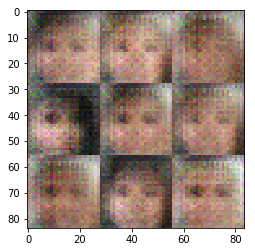

Epoch 1/20... Discriminator Loss: 1.5035... Generator Loss: 0.6076
Epoch 1/20... Discriminator Loss: 1.4528... Generator Loss: 0.5828
Epoch 1/20... Discriminator Loss: 1.4839... Generator Loss: 0.5702
Epoch 1/20... Discriminator Loss: 1.4821... Generator Loss: 0.5379
Epoch 1/20... Discriminator Loss: 1.4866... Generator Loss: 0.6338
Epoch 1/20... Discriminator Loss: 1.5135... Generator Loss: 0.5878
Epoch 1/20... Discriminator Loss: 1.4702... Generator Loss: 0.5989
Epoch 1/20... Discriminator Loss: 1.4604... Generator Loss: 0.6224
Epoch 1/20... Discriminator Loss: 1.5350... Generator Loss: 0.6015
Epoch 1/20... Discriminator Loss: 1.5253... Generator Loss: 0.5567
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


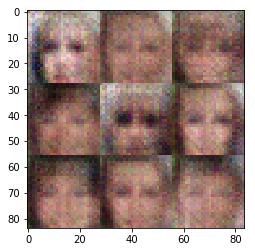

Epoch 1/20... Discriminator Loss: 1.4747... Generator Loss: 0.6376
Epoch 1/20... Discriminator Loss: 1.4739... Generator Loss: 0.5786
Epoch 1/20... Discriminator Loss: 1.5018... Generator Loss: 0.5323
Epoch 1/20... Discriminator Loss: 1.6138... Generator Loss: 0.5168
Epoch 1/20... Discriminator Loss: 1.5381... Generator Loss: 0.5356
Epoch 1/20... Discriminator Loss: 1.5975... Generator Loss: 0.5076
Epoch 1/20... Discriminator Loss: 1.4509... Generator Loss: 0.5868
Epoch 1/20... Discriminator Loss: 1.4524... Generator Loss: 0.6215
Epoch 1/20... Discriminator Loss: 1.5293... Generator Loss: 0.5714
Epoch 1/20... Discriminator Loss: 1.4365... Generator Loss: 0.6650
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


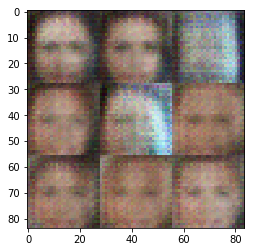

Epoch 1/20... Discriminator Loss: 1.4926... Generator Loss: 0.6020
Epoch 1/20... Discriminator Loss: 1.5484... Generator Loss: 0.5581
Epoch 1/20... Discriminator Loss: 1.4821... Generator Loss: 0.6311
Epoch 1/20... Discriminator Loss: 1.4322... Generator Loss: 0.6812
Epoch 1/20... Discriminator Loss: 1.4924... Generator Loss: 0.6022
Epoch 1/20... Discriminator Loss: 1.6840... Generator Loss: 0.4976
Epoch 1/20... Discriminator Loss: 1.4199... Generator Loss: 0.6147
Epoch 1/20... Discriminator Loss: 1.5043... Generator Loss: 0.5731
Epoch 1/20... Discriminator Loss: 1.4795... Generator Loss: 0.5555
Epoch 1/20... Discriminator Loss: 1.4790... Generator Loss: 0.6035
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


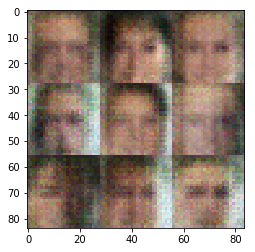

Epoch 1/20... Discriminator Loss: 1.4571... Generator Loss: 0.5803
Epoch 1/20... Discriminator Loss: 1.5293... Generator Loss: 0.6471
Epoch 1/20... Discriminator Loss: 1.4495... Generator Loss: 0.6291
Epoch 1/20... Discriminator Loss: 1.5684... Generator Loss: 0.5814
Epoch 1/20... Discriminator Loss: 1.4542... Generator Loss: 0.6282
Epoch 1/20... Discriminator Loss: 1.4170... Generator Loss: 0.6423
Epoch 1/20... Discriminator Loss: 1.4893... Generator Loss: 0.6241
Epoch 1/20... Discriminator Loss: 1.4400... Generator Loss: 0.5927
Epoch 1/20... Discriminator Loss: 1.5029... Generator Loss: 0.6132
Epoch 1/20... Discriminator Loss: 1.4795... Generator Loss: 0.6356
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


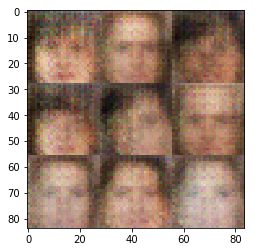

Epoch 1/20... Discriminator Loss: 1.4530... Generator Loss: 0.6452
Epoch 1/20... Discriminator Loss: 1.4969... Generator Loss: 0.6448
Epoch 1/20... Discriminator Loss: 1.4698... Generator Loss: 0.6117
Epoch 1/20... Discriminator Loss: 1.4798... Generator Loss: 0.5851
Epoch 1/20... Discriminator Loss: 1.4711... Generator Loss: 0.5993
Epoch 1/20... Discriminator Loss: 1.4442... Generator Loss: 0.6727
Epoch 1/20... Discriminator Loss: 1.5053... Generator Loss: 0.5439
Epoch 1/20... Discriminator Loss: 1.4178... Generator Loss: 0.6070
Epoch 1/20... Discriminator Loss: 1.4683... Generator Loss: 0.6281
Epoch 1/20... Discriminator Loss: 1.5072... Generator Loss: 0.6449
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


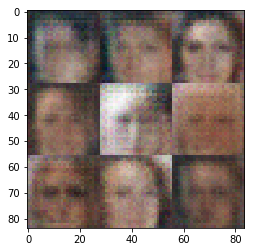

Epoch 1/20... Discriminator Loss: 1.4648... Generator Loss: 0.6422
Epoch 1/20... Discriminator Loss: 1.4195... Generator Loss: 0.6520
Epoch 1/20... Discriminator Loss: 1.4524... Generator Loss: 0.6085
Epoch 1/20... Discriminator Loss: 1.3855... Generator Loss: 0.6789
Epoch 1/20... Discriminator Loss: 1.4253... Generator Loss: 0.6316
Epoch 1/20... Discriminator Loss: 1.4667... Generator Loss: 0.6361
Epoch 1/20... Discriminator Loss: 1.4896... Generator Loss: 0.6017
Epoch 1/20... Discriminator Loss: 1.4869... Generator Loss: 0.6912
Epoch 1/20... Discriminator Loss: 1.4806... Generator Loss: 0.6119
Epoch 1/20... Discriminator Loss: 1.4944... Generator Loss: 0.6196
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


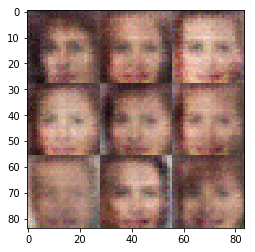

Epoch 1/20... Discriminator Loss: 1.4506... Generator Loss: 0.5773
Epoch 1/20... Discriminator Loss: 1.4024... Generator Loss: 0.6969
Epoch 1/20... Discriminator Loss: 1.4141... Generator Loss: 0.6497
Epoch 1/20... Discriminator Loss: 1.4176... Generator Loss: 0.6279
Epoch 1/20... Discriminator Loss: 1.4861... Generator Loss: 0.6105
Epoch 1/20... Discriminator Loss: 1.4736... Generator Loss: 0.6300
Epoch 1/20... Discriminator Loss: 1.4972... Generator Loss: 0.6235
Epoch 1/20... Discriminator Loss: 1.4989... Generator Loss: 0.5959
Epoch 1/20... Discriminator Loss: 1.4933... Generator Loss: 0.6433
Epoch 1/20... Discriminator Loss: 1.4198... Generator Loss: 0.7215
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


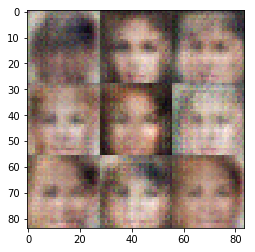

Epoch 1/20... Discriminator Loss: 1.4494... Generator Loss: 0.6507
Epoch 1/20... Discriminator Loss: 1.4352... Generator Loss: 0.5918
Epoch 1/20... Discriminator Loss: 1.4868... Generator Loss: 0.5830
Epoch 1/20... Discriminator Loss: 1.4031... Generator Loss: 0.5698
Epoch 1/20... Discriminator Loss: 1.5097... Generator Loss: 0.6481
Epoch 1/20... Discriminator Loss: 1.4902... Generator Loss: 0.5930
Epoch 1/20... Discriminator Loss: 1.4308... Generator Loss: 0.5914
Epoch 1/20... Discriminator Loss: 1.4089... Generator Loss: 0.6863
Epoch 1/20... Discriminator Loss: 1.4436... Generator Loss: 0.6914
Epoch 1/20... Discriminator Loss: 1.4383... Generator Loss: 0.6573
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


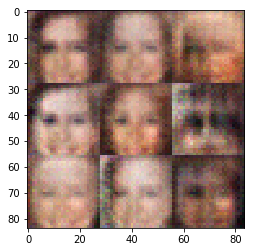

Epoch 1/20... Discriminator Loss: 1.4938... Generator Loss: 0.5521
Epoch 1/20... Discriminator Loss: 1.4324... Generator Loss: 0.6187
Epoch 1/20... Discriminator Loss: 1.4742... Generator Loss: 0.7291
Epoch 1/20... Discriminator Loss: 1.4581... Generator Loss: 0.6667
Epoch 1/20... Discriminator Loss: 1.4848... Generator Loss: 0.5374
Epoch 1/20... Discriminator Loss: 1.4465... Generator Loss: 0.5809
Epoch 1/20... Discriminator Loss: 1.4609... Generator Loss: 0.6383
Epoch 1/20... Discriminator Loss: 1.4868... Generator Loss: 0.6609
Epoch 1/20... Discriminator Loss: 1.4496... Generator Loss: 0.6231
Epoch 1/20... Discriminator Loss: 1.4581... Generator Loss: 0.6344
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


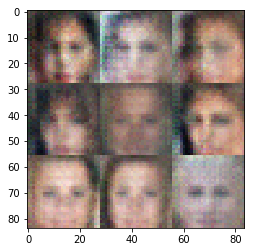

Epoch 1/20... Discriminator Loss: 1.4704... Generator Loss: 0.6179
Epoch 1/20... Discriminator Loss: 1.5302... Generator Loss: 0.5201
Epoch 1/20... Discriminator Loss: 1.4367... Generator Loss: 0.6056
Epoch 1/20... Discriminator Loss: 1.4838... Generator Loss: 0.6181
Epoch 1/20... Discriminator Loss: 1.5006... Generator Loss: 0.6681
Epoch 1/20... Discriminator Loss: 1.4784... Generator Loss: 0.6102
Epoch 1/20... Discriminator Loss: 1.4307... Generator Loss: 0.6554
Epoch 1/20... Discriminator Loss: 1.4442... Generator Loss: 0.6377
Epoch 1/20... Discriminator Loss: 1.4788... Generator Loss: 0.5776
Epoch 1/20... Discriminator Loss: 1.4453... Generator Loss: 0.5815
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


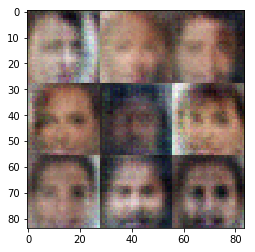

Epoch 1/20... Discriminator Loss: 1.4673... Generator Loss: 0.6709
Epoch 1/20... Discriminator Loss: 1.4421... Generator Loss: 0.6808
Epoch 1/20... Discriminator Loss: 1.4729... Generator Loss: 0.5311
Epoch 1/20... Discriminator Loss: 1.4884... Generator Loss: 0.5493
Epoch 1/20... Discriminator Loss: 1.4004... Generator Loss: 0.7284
Epoch 1/20... Discriminator Loss: 1.4669... Generator Loss: 0.6174
Epoch 1/20... Discriminator Loss: 1.4412... Generator Loss: 0.5970
Epoch 1/20... Discriminator Loss: 1.4076... Generator Loss: 0.6515
Epoch 1/20... Discriminator Loss: 1.4145... Generator Loss: 0.6788
Epoch 1/20... Discriminator Loss: 1.4342... Generator Loss: 0.6867
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


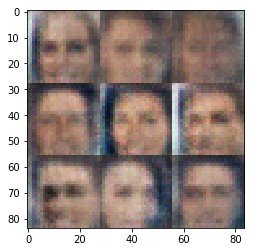

Epoch 1/20... Discriminator Loss: 1.4754... Generator Loss: 0.5535
Epoch 1/20... Discriminator Loss: 1.4480... Generator Loss: 0.6208
Epoch 1/20... Discriminator Loss: 1.4389... Generator Loss: 0.7252
Epoch 1/20... Discriminator Loss: 1.5347... Generator Loss: 0.6578
Epoch 1/20... Discriminator Loss: 1.4631... Generator Loss: 0.6565
Epoch 1/20... Discriminator Loss: 1.4919... Generator Loss: 0.6720
Epoch 1/20... Discriminator Loss: 1.4637... Generator Loss: 0.5587
Epoch 1/20... Discriminator Loss: 1.5079... Generator Loss: 0.5784
Time for previous epoch: 10465.76159453392
Time till previous epoch: 10481.328150987625
Epoch 2/20... Discriminator Loss: 1.4304... Generator Loss: 0.6042
Epoch 2/20... Discriminator Loss: 1.4680... Generator Loss: 0.7896
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


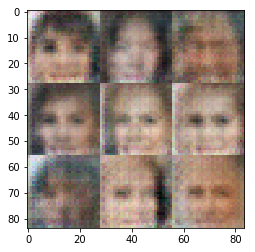

Epoch 2/20... Discriminator Loss: 1.3914... Generator Loss: 0.6902
Epoch 2/20... Discriminator Loss: 1.4720... Generator Loss: 0.6525
Epoch 2/20... Discriminator Loss: 1.4639... Generator Loss: 0.5815
Epoch 2/20... Discriminator Loss: 1.5098... Generator Loss: 0.6784
Epoch 2/20... Discriminator Loss: 1.4629... Generator Loss: 0.5768
Epoch 2/20... Discriminator Loss: 1.4615... Generator Loss: 0.6749
Epoch 2/20... Discriminator Loss: 1.4242... Generator Loss: 0.6074
Epoch 2/20... Discriminator Loss: 1.4231... Generator Loss: 0.6292
Epoch 2/20... Discriminator Loss: 1.4659... Generator Loss: 0.5346
Epoch 2/20... Discriminator Loss: 1.4050... Generator Loss: 0.6243
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


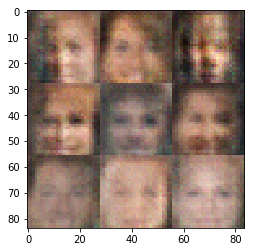

Epoch 2/20... Discriminator Loss: 1.4260... Generator Loss: 0.6953
Epoch 2/20... Discriminator Loss: 1.4215... Generator Loss: 0.6625
Epoch 2/20... Discriminator Loss: 1.4802... Generator Loss: 0.5704
Epoch 2/20... Discriminator Loss: 1.4219... Generator Loss: 0.5825
Epoch 2/20... Discriminator Loss: 1.4469... Generator Loss: 0.6778
Epoch 2/20... Discriminator Loss: 1.4875... Generator Loss: 0.5877
Epoch 2/20... Discriminator Loss: 1.4420... Generator Loss: 0.5732
Epoch 2/20... Discriminator Loss: 1.4614... Generator Loss: 0.6158
Epoch 2/20... Discriminator Loss: 1.4183... Generator Loss: 0.6692
Epoch 2/20... Discriminator Loss: 1.4625... Generator Loss: 0.6369
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


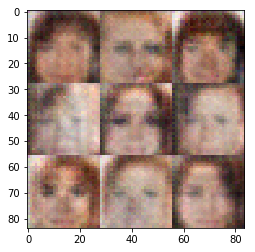

Epoch 2/20... Discriminator Loss: 1.4928... Generator Loss: 0.7230
Epoch 2/20... Discriminator Loss: 1.5108... Generator Loss: 0.5530
Epoch 2/20... Discriminator Loss: 1.4346... Generator Loss: 0.6428
Epoch 2/20... Discriminator Loss: 1.4922... Generator Loss: 0.6798
Epoch 2/20... Discriminator Loss: 1.4094... Generator Loss: 0.6608
Epoch 2/20... Discriminator Loss: 1.4837... Generator Loss: 0.5709
Epoch 2/20... Discriminator Loss: 1.4974... Generator Loss: 0.6549
Epoch 2/20... Discriminator Loss: 1.4476... Generator Loss: 0.6379
Epoch 2/20... Discriminator Loss: 1.4362... Generator Loss: 0.5613
Epoch 2/20... Discriminator Loss: 1.4482... Generator Loss: 0.5211
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


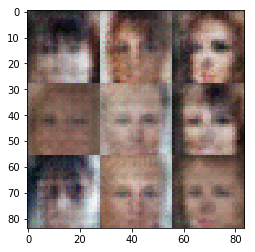

Epoch 2/20... Discriminator Loss: 1.4681... Generator Loss: 0.5383
Epoch 2/20... Discriminator Loss: 1.4988... Generator Loss: 0.5525
Epoch 2/20... Discriminator Loss: 1.5553... Generator Loss: 0.6024
Epoch 2/20... Discriminator Loss: 1.4234... Generator Loss: 0.6262
Epoch 2/20... Discriminator Loss: 1.4615... Generator Loss: 0.6950
Epoch 2/20... Discriminator Loss: 1.4316... Generator Loss: 0.6848
Epoch 2/20... Discriminator Loss: 1.4625... Generator Loss: 0.6249
Epoch 2/20... Discriminator Loss: 1.4993... Generator Loss: 0.6196
Epoch 2/20... Discriminator Loss: 1.4980... Generator Loss: 0.6516
Epoch 2/20... Discriminator Loss: 1.4307... Generator Loss: 0.6842
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


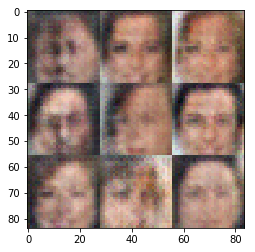

Epoch 2/20... Discriminator Loss: 1.4358... Generator Loss: 0.6615
Epoch 2/20... Discriminator Loss: 1.4102... Generator Loss: 0.6002
Epoch 2/20... Discriminator Loss: 1.5238... Generator Loss: 0.5329
Epoch 2/20... Discriminator Loss: 1.4535... Generator Loss: 0.5913
Epoch 2/20... Discriminator Loss: 1.4612... Generator Loss: 0.7147
Epoch 2/20... Discriminator Loss: 1.4585... Generator Loss: 0.5500
Epoch 2/20... Discriminator Loss: 1.4512... Generator Loss: 0.5641
Epoch 2/20... Discriminator Loss: 1.4386... Generator Loss: 0.6566
Epoch 2/20... Discriminator Loss: 1.4882... Generator Loss: 0.5427
Epoch 2/20... Discriminator Loss: 1.4767... Generator Loss: 0.6041
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


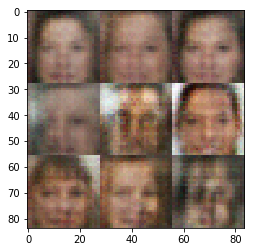

Epoch 2/20... Discriminator Loss: 1.4706... Generator Loss: 0.6588
Epoch 2/20... Discriminator Loss: 1.3981... Generator Loss: 0.6101
Epoch 2/20... Discriminator Loss: 1.4915... Generator Loss: 0.6185
Epoch 2/20... Discriminator Loss: 1.4108... Generator Loss: 0.7323
Epoch 2/20... Discriminator Loss: 1.4426... Generator Loss: 0.6119
Epoch 2/20... Discriminator Loss: 1.4430... Generator Loss: 0.6492
Epoch 2/20... Discriminator Loss: 1.5037... Generator Loss: 0.6034
Epoch 2/20... Discriminator Loss: 1.4870... Generator Loss: 0.7843
Epoch 2/20... Discriminator Loss: 1.4532... Generator Loss: 0.6164
Epoch 2/20... Discriminator Loss: 1.4247... Generator Loss: 0.6474
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


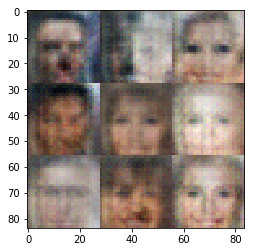

Epoch 2/20... Discriminator Loss: 1.4706... Generator Loss: 0.5672
Epoch 2/20... Discriminator Loss: 1.4111... Generator Loss: 0.6413
Epoch 2/20... Discriminator Loss: 1.4769... Generator Loss: 0.5236
Epoch 2/20... Discriminator Loss: 1.4641... Generator Loss: 0.5734
Epoch 2/20... Discriminator Loss: 1.4439... Generator Loss: 0.7628
Epoch 2/20... Discriminator Loss: 1.4340... Generator Loss: 0.7285
Epoch 2/20... Discriminator Loss: 1.4518... Generator Loss: 0.6802
Epoch 2/20... Discriminator Loss: 1.4917... Generator Loss: 0.6729
Epoch 2/20... Discriminator Loss: 1.4237... Generator Loss: 0.6954
Epoch 2/20... Discriminator Loss: 1.4205... Generator Loss: 0.6004
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


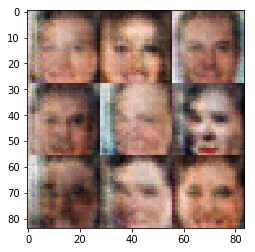

Epoch 2/20... Discriminator Loss: 1.5415... Generator Loss: 0.5148
Epoch 2/20... Discriminator Loss: 1.4549... Generator Loss: 0.5312
Epoch 2/20... Discriminator Loss: 1.4631... Generator Loss: 0.6483
Epoch 2/20... Discriminator Loss: 1.4512... Generator Loss: 0.6742
Epoch 2/20... Discriminator Loss: 1.4470... Generator Loss: 0.6012
Epoch 2/20... Discriminator Loss: 1.4558... Generator Loss: 0.6569
Epoch 2/20... Discriminator Loss: 1.4628... Generator Loss: 0.5544
Epoch 2/20... Discriminator Loss: 1.4618... Generator Loss: 0.5675
Epoch 2/20... Discriminator Loss: 1.4633... Generator Loss: 0.6674
Epoch 2/20... Discriminator Loss: 1.4286... Generator Loss: 0.6816
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


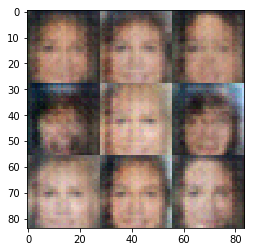

Epoch 2/20... Discriminator Loss: 1.4308... Generator Loss: 0.5659
Epoch 2/20... Discriminator Loss: 1.5152... Generator Loss: 0.5015
Epoch 2/20... Discriminator Loss: 1.4485... Generator Loss: 0.6413
Epoch 2/20... Discriminator Loss: 1.4333... Generator Loss: 0.6151
Epoch 2/20... Discriminator Loss: 1.4141... Generator Loss: 0.6667
Epoch 2/20... Discriminator Loss: 1.4422... Generator Loss: 0.7736
Epoch 2/20... Discriminator Loss: 1.4264... Generator Loss: 0.6555
Epoch 2/20... Discriminator Loss: 1.4279... Generator Loss: 0.6921
Epoch 2/20... Discriminator Loss: 1.4454... Generator Loss: 0.6759
Epoch 2/20... Discriminator Loss: 1.4070... Generator Loss: 0.6378
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


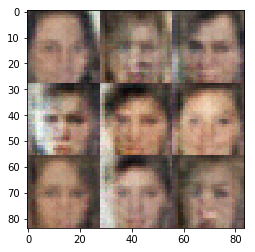

Epoch 2/20... Discriminator Loss: 1.5559... Generator Loss: 0.4334
Epoch 2/20... Discriminator Loss: 1.4259... Generator Loss: 0.6335
Epoch 2/20... Discriminator Loss: 1.4546... Generator Loss: 0.6841
Epoch 2/20... Discriminator Loss: 1.4374... Generator Loss: 0.6966
Epoch 2/20... Discriminator Loss: 1.4582... Generator Loss: 0.5708
Epoch 2/20... Discriminator Loss: 1.4779... Generator Loss: 0.5537
Epoch 2/20... Discriminator Loss: 1.4162... Generator Loss: 0.7228
Epoch 2/20... Discriminator Loss: 1.4461... Generator Loss: 0.7399
Epoch 2/20... Discriminator Loss: 1.4626... Generator Loss: 0.6291
Epoch 2/20... Discriminator Loss: 1.4252... Generator Loss: 0.5875
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


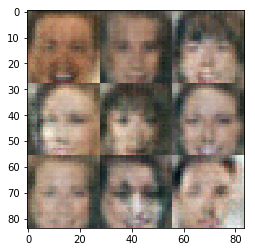

Epoch 2/20... Discriminator Loss: 1.4293... Generator Loss: 0.7562
Epoch 2/20... Discriminator Loss: 1.4419... Generator Loss: 0.5293
Epoch 2/20... Discriminator Loss: 1.5739... Generator Loss: 0.5261
Epoch 2/20... Discriminator Loss: 1.5012... Generator Loss: 0.5302
Epoch 2/20... Discriminator Loss: 1.4713... Generator Loss: 0.5498
Epoch 2/20... Discriminator Loss: 1.4670... Generator Loss: 0.6040
Epoch 2/20... Discriminator Loss: 1.4264... Generator Loss: 0.5829
Epoch 2/20... Discriminator Loss: 1.4509... Generator Loss: 0.5966
Epoch 2/20... Discriminator Loss: 1.4228... Generator Loss: 0.7215
Epoch 2/20... Discriminator Loss: 1.4712... Generator Loss: 0.6525
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


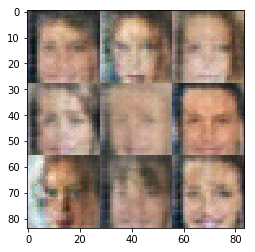

Epoch 2/20... Discriminator Loss: 1.4326... Generator Loss: 0.7376
Epoch 2/20... Discriminator Loss: 1.4425... Generator Loss: 0.6145
Epoch 2/20... Discriminator Loss: 1.4387... Generator Loss: 0.6439
Epoch 2/20... Discriminator Loss: 1.5965... Generator Loss: 0.4572
Epoch 2/20... Discriminator Loss: 1.4385... Generator Loss: 0.6270
Epoch 2/20... Discriminator Loss: 1.4032... Generator Loss: 0.7980
Epoch 2/20... Discriminator Loss: 1.5311... Generator Loss: 0.5927
Epoch 2/20... Discriminator Loss: 1.5374... Generator Loss: 0.7096
Epoch 2/20... Discriminator Loss: 1.4570... Generator Loss: 0.5686
Epoch 2/20... Discriminator Loss: 1.4337... Generator Loss: 0.7097
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


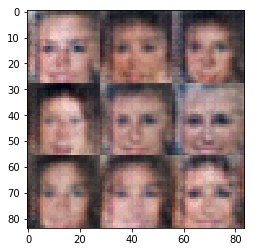

Epoch 2/20... Discriminator Loss: 1.4400... Generator Loss: 0.5169
Epoch 2/20... Discriminator Loss: 1.4360... Generator Loss: 0.9619
Epoch 2/20... Discriminator Loss: 1.4453... Generator Loss: 0.6375
Epoch 2/20... Discriminator Loss: 1.5273... Generator Loss: 0.5484
Epoch 2/20... Discriminator Loss: 1.4262... Generator Loss: 0.6568
Epoch 2/20... Discriminator Loss: 1.4483... Generator Loss: 0.6662
Epoch 2/20... Discriminator Loss: 1.4136... Generator Loss: 0.6040
Epoch 2/20... Discriminator Loss: 1.4460... Generator Loss: 0.7461
Epoch 2/20... Discriminator Loss: 1.5242... Generator Loss: 0.5063
Epoch 2/20... Discriminator Loss: 1.4786... Generator Loss: 0.4833
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


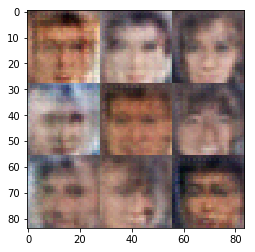

Epoch 2/20... Discriminator Loss: 1.4658... Generator Loss: 0.5669
Epoch 2/20... Discriminator Loss: 1.5228... Generator Loss: 0.6290
Epoch 2/20... Discriminator Loss: 1.4565... Generator Loss: 0.6302
Epoch 2/20... Discriminator Loss: 1.4915... Generator Loss: 0.6478
Epoch 2/20... Discriminator Loss: 1.4160... Generator Loss: 0.6972
Epoch 2/20... Discriminator Loss: 1.4460... Generator Loss: 0.6076
Epoch 2/20... Discriminator Loss: 1.4424... Generator Loss: 0.5761
Epoch 2/20... Discriminator Loss: 1.4905... Generator Loss: 0.5363
Epoch 2/20... Discriminator Loss: 1.4438... Generator Loss: 0.7011
Epoch 2/20... Discriminator Loss: 1.4318... Generator Loss: 0.6516
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


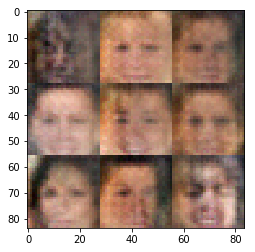

Epoch 2/20... Discriminator Loss: 1.4157... Generator Loss: 0.7290
Epoch 2/20... Discriminator Loss: 1.5116... Generator Loss: 0.5683
Epoch 2/20... Discriminator Loss: 1.4141... Generator Loss: 0.6183
Epoch 2/20... Discriminator Loss: 1.4767... Generator Loss: 0.5304
Epoch 2/20... Discriminator Loss: 1.5253... Generator Loss: 0.6252
Epoch 2/20... Discriminator Loss: 1.4771... Generator Loss: 0.5251
Epoch 2/20... Discriminator Loss: 1.4607... Generator Loss: 0.6301
Epoch 2/20... Discriminator Loss: 1.4721... Generator Loss: 0.6732
Epoch 2/20... Discriminator Loss: 1.4231... Generator Loss: 0.6057
Epoch 2/20... Discriminator Loss: 1.3920... Generator Loss: 0.5580
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


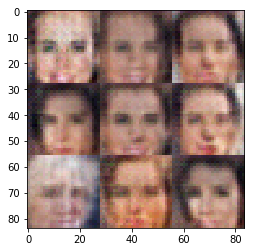

Epoch 2/20... Discriminator Loss: 1.6456... Generator Loss: 1.2148
Epoch 2/20... Discriminator Loss: 1.4250... Generator Loss: 0.6900
Epoch 2/20... Discriminator Loss: 1.4289... Generator Loss: 0.5351
Epoch 2/20... Discriminator Loss: 1.4738... Generator Loss: 0.4176
Epoch 2/20... Discriminator Loss: 1.4773... Generator Loss: 0.5556
Epoch 2/20... Discriminator Loss: 1.4897... Generator Loss: 0.4905
Time for previous epoch: 10203.100152492523
Time till previous epoch: 20684.446303606033
Epoch 3/20... Discriminator Loss: 1.4396... Generator Loss: 0.5855
Epoch 3/20... Discriminator Loss: 1.4795... Generator Loss: 0.5728
Epoch 3/20... Discriminator Loss: 1.4984... Generator Loss: 0.8904
Epoch 3/20... Discriminator Loss: 1.5072... Generator Loss: 1.0201
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


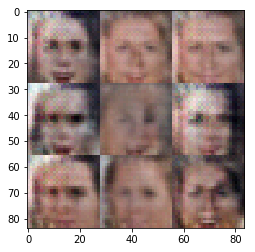

Epoch 3/20... Discriminator Loss: 1.5121... Generator Loss: 0.5493
Epoch 3/20... Discriminator Loss: 1.3732... Generator Loss: 0.6282
Epoch 3/20... Discriminator Loss: 1.4390... Generator Loss: 0.5449
Epoch 3/20... Discriminator Loss: 1.4809... Generator Loss: 0.5888
Epoch 3/20... Discriminator Loss: 1.4962... Generator Loss: 0.5791
Epoch 3/20... Discriminator Loss: 1.4311... Generator Loss: 0.6749
Epoch 3/20... Discriminator Loss: 1.3692... Generator Loss: 0.6854
Epoch 3/20... Discriminator Loss: 1.4513... Generator Loss: 0.6583
Epoch 3/20... Discriminator Loss: 1.4823... Generator Loss: 0.6002
Epoch 3/20... Discriminator Loss: 1.4791... Generator Loss: 0.5285
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


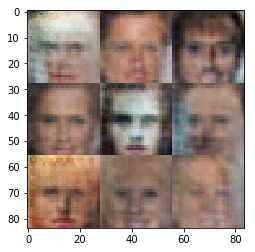

Epoch 3/20... Discriminator Loss: 1.4278... Generator Loss: 0.6709
Epoch 3/20... Discriminator Loss: 1.5971... Generator Loss: 0.5311
Epoch 3/20... Discriminator Loss: 1.4500... Generator Loss: 0.5458
Epoch 3/20... Discriminator Loss: 1.4946... Generator Loss: 0.4683
Epoch 3/20... Discriminator Loss: 1.4866... Generator Loss: 0.5558
Epoch 3/20... Discriminator Loss: 1.4335... Generator Loss: 0.6528
Epoch 3/20... Discriminator Loss: 1.4387... Generator Loss: 0.6617
Epoch 3/20... Discriminator Loss: 1.4503... Generator Loss: 0.6367
Epoch 3/20... Discriminator Loss: 1.3797... Generator Loss: 0.6375
Epoch 3/20... Discriminator Loss: 1.4676... Generator Loss: 0.5627
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


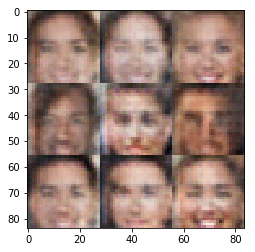

Epoch 3/20... Discriminator Loss: 1.4925... Generator Loss: 0.6075
Epoch 3/20... Discriminator Loss: 1.4316... Generator Loss: 0.5761
Epoch 3/20... Discriminator Loss: 1.4283... Generator Loss: 0.6671
Epoch 3/20... Discriminator Loss: 1.4674... Generator Loss: 0.5293
Epoch 3/20... Discriminator Loss: 1.5037... Generator Loss: 0.5896
Epoch 3/20... Discriminator Loss: 1.4761... Generator Loss: 0.4995
Epoch 3/20... Discriminator Loss: 1.4124... Generator Loss: 0.6413
Epoch 3/20... Discriminator Loss: 1.3789... Generator Loss: 0.7831
Epoch 3/20... Discriminator Loss: 1.4431... Generator Loss: 0.5077
Epoch 3/20... Discriminator Loss: 1.4584... Generator Loss: 0.5118
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


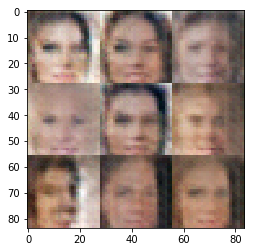

Epoch 3/20... Discriminator Loss: 1.4865... Generator Loss: 0.6657
Epoch 3/20... Discriminator Loss: 1.4935... Generator Loss: 0.5065
Epoch 3/20... Discriminator Loss: 1.4985... Generator Loss: 0.5366
Epoch 3/20... Discriminator Loss: 1.4211... Generator Loss: 0.6853
Epoch 3/20... Discriminator Loss: 1.4759... Generator Loss: 0.5177
Epoch 3/20... Discriminator Loss: 1.4234... Generator Loss: 0.5829
Epoch 3/20... Discriminator Loss: 1.4336... Generator Loss: 0.6576
Epoch 3/20... Discriminator Loss: 1.4984... Generator Loss: 0.4639
Epoch 3/20... Discriminator Loss: 1.4277... Generator Loss: 0.5753
Epoch 3/20... Discriminator Loss: 1.4946... Generator Loss: 0.6146
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


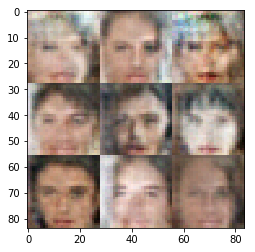

Epoch 3/20... Discriminator Loss: 1.3894... Generator Loss: 0.5855
Epoch 3/20... Discriminator Loss: 1.4143... Generator Loss: 0.8052
Epoch 3/20... Discriminator Loss: 1.4046... Generator Loss: 0.8211
Epoch 3/20... Discriminator Loss: 1.4551... Generator Loss: 0.4905
Epoch 3/20... Discriminator Loss: 1.3673... Generator Loss: 0.6735
Epoch 3/20... Discriminator Loss: 1.4260... Generator Loss: 0.6578
Epoch 3/20... Discriminator Loss: 1.4996... Generator Loss: 0.5121
Epoch 3/20... Discriminator Loss: 1.4212... Generator Loss: 1.5015
Epoch 3/20... Discriminator Loss: 1.4698... Generator Loss: 0.6071
Epoch 3/20... Discriminator Loss: 1.3677... Generator Loss: 0.6826
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


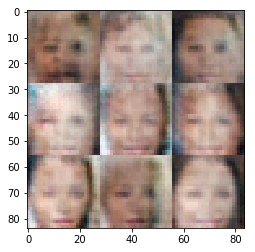

Epoch 3/20... Discriminator Loss: 1.5116... Generator Loss: 0.4561
Epoch 3/20... Discriminator Loss: 1.3838... Generator Loss: 0.7214
Epoch 3/20... Discriminator Loss: 1.4873... Generator Loss: 0.6739
Epoch 3/20... Discriminator Loss: 1.5328... Generator Loss: 0.3494
Epoch 3/20... Discriminator Loss: 1.4296... Generator Loss: 0.5278
Epoch 3/20... Discriminator Loss: 1.4433... Generator Loss: 0.9307
Epoch 3/20... Discriminator Loss: 1.3369... Generator Loss: 0.4844
Epoch 3/20... Discriminator Loss: 1.2667... Generator Loss: 0.8246
Epoch 3/20... Discriminator Loss: 1.6624... Generator Loss: 0.3485
Epoch 3/20... Discriminator Loss: 1.9517... Generator Loss: 1.5187
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


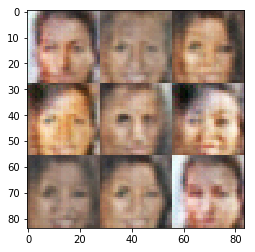

Epoch 3/20... Discriminator Loss: 1.4824... Generator Loss: 0.4433
Epoch 3/20... Discriminator Loss: 1.2155... Generator Loss: 1.5122
Epoch 3/20... Discriminator Loss: 1.0944... Generator Loss: 1.0530
Epoch 3/20... Discriminator Loss: 1.3065... Generator Loss: 0.5499
Epoch 3/20... Discriminator Loss: 1.1502... Generator Loss: 1.2676
Epoch 3/20... Discriminator Loss: 1.1104... Generator Loss: 0.8676
Epoch 3/20... Discriminator Loss: 1.2145... Generator Loss: 0.6293
Epoch 3/20... Discriminator Loss: 1.5327... Generator Loss: 0.7093
Epoch 3/20... Discriminator Loss: 1.3500... Generator Loss: 0.5885
Epoch 3/20... Discriminator Loss: 1.0165... Generator Loss: 2.1932
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


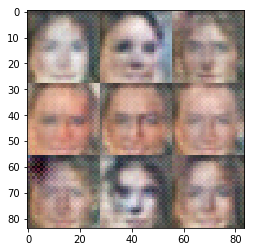

Epoch 3/20... Discriminator Loss: 1.0838... Generator Loss: 0.8331
Epoch 3/20... Discriminator Loss: 1.2291... Generator Loss: 1.1950
Epoch 3/20... Discriminator Loss: 1.3849... Generator Loss: 0.9769
Epoch 3/20... Discriminator Loss: 1.5567... Generator Loss: 1.3141
Epoch 3/20... Discriminator Loss: 1.2746... Generator Loss: 0.6163
Epoch 3/20... Discriminator Loss: 1.2844... Generator Loss: 1.6375
Epoch 3/20... Discriminator Loss: 1.7190... Generator Loss: 0.2404
Epoch 3/20... Discriminator Loss: 1.1427... Generator Loss: 1.0791
Epoch 3/20... Discriminator Loss: 0.3642... Generator Loss: 2.2028
Epoch 3/20... Discriminator Loss: 1.4472... Generator Loss: 0.7476
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


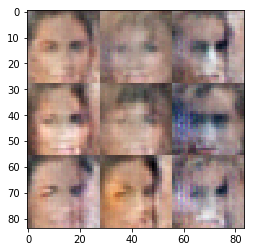

Epoch 3/20... Discriminator Loss: 1.4316... Generator Loss: 0.6238
Epoch 3/20... Discriminator Loss: 1.2316... Generator Loss: 0.8584
Epoch 3/20... Discriminator Loss: 1.3072... Generator Loss: 0.5560
Epoch 3/20... Discriminator Loss: 1.2568... Generator Loss: 0.7125
Epoch 3/20... Discriminator Loss: 1.4564... Generator Loss: 0.4826
Epoch 3/20... Discriminator Loss: 0.9585... Generator Loss: 1.3494
Epoch 3/20... Discriminator Loss: 1.5322... Generator Loss: 0.3208
Epoch 3/20... Discriminator Loss: 0.3188... Generator Loss: 3.5055
Epoch 3/20... Discriminator Loss: 1.8066... Generator Loss: 0.2454
Epoch 3/20... Discriminator Loss: 1.3498... Generator Loss: 0.6841
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


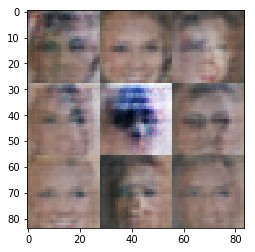

Epoch 3/20... Discriminator Loss: 1.2740... Generator Loss: 0.6932
Epoch 3/20... Discriminator Loss: 1.3809... Generator Loss: 0.5946
Epoch 3/20... Discriminator Loss: 1.4014... Generator Loss: 0.6401
Epoch 3/20... Discriminator Loss: 1.1712... Generator Loss: 0.7878
Epoch 3/20... Discriminator Loss: 0.4081... Generator Loss: 2.7577
Epoch 3/20... Discriminator Loss: 2.0945... Generator Loss: 0.1662
Epoch 3/20... Discriminator Loss: 1.1007... Generator Loss: 1.0869
Epoch 3/20... Discriminator Loss: 2.7282... Generator Loss: 3.6570
Epoch 3/20... Discriminator Loss: 1.1101... Generator Loss: 0.9007
Epoch 3/20... Discriminator Loss: 1.3460... Generator Loss: 1.4678
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


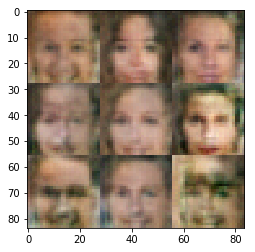

Epoch 3/20... Discriminator Loss: 1.0536... Generator Loss: 1.3600
Epoch 3/20... Discriminator Loss: 0.9538... Generator Loss: 0.7304
Epoch 3/20... Discriminator Loss: 1.4768... Generator Loss: 0.5749
Epoch 3/20... Discriminator Loss: 1.4335... Generator Loss: 0.6037
Epoch 3/20... Discriminator Loss: 1.4231... Generator Loss: 0.5992
Epoch 3/20... Discriminator Loss: 1.4014... Generator Loss: 0.5736
Epoch 3/20... Discriminator Loss: 1.2637... Generator Loss: 0.7684
Epoch 3/20... Discriminator Loss: 1.1894... Generator Loss: 0.6636
Epoch 3/20... Discriminator Loss: 1.3856... Generator Loss: 0.6764
Epoch 3/20... Discriminator Loss: 1.3937... Generator Loss: 0.5422
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


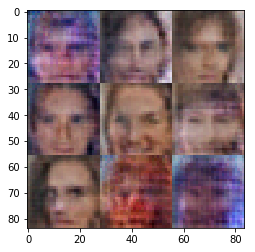

Epoch 3/20... Discriminator Loss: 1.2596... Generator Loss: 0.6823
Epoch 3/20... Discriminator Loss: 1.2619... Generator Loss: 0.6543
Epoch 3/20... Discriminator Loss: 1.2864... Generator Loss: 0.8944
Epoch 3/20... Discriminator Loss: 1.3712... Generator Loss: 0.6777
Epoch 3/20... Discriminator Loss: 1.0482... Generator Loss: 0.8692
Epoch 3/20... Discriminator Loss: 1.2417... Generator Loss: 0.7365
Epoch 3/20... Discriminator Loss: 1.0942... Generator Loss: 0.8201
Epoch 3/20... Discriminator Loss: 1.5365... Generator Loss: 0.3023
Epoch 3/20... Discriminator Loss: 1.0589... Generator Loss: 0.9049
Epoch 3/20... Discriminator Loss: 1.2786... Generator Loss: 0.6480
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


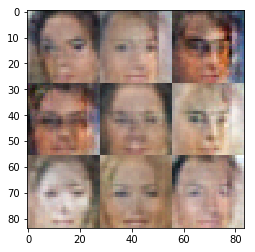

Epoch 3/20... Discriminator Loss: 1.3770... Generator Loss: 0.6066
Epoch 3/20... Discriminator Loss: 1.3833... Generator Loss: 1.1603
Epoch 3/20... Discriminator Loss: 1.1494... Generator Loss: 3.1268
Epoch 3/20... Discriminator Loss: 1.3273... Generator Loss: 0.5133
Epoch 3/20... Discriminator Loss: 1.1539... Generator Loss: 0.8190
Epoch 3/20... Discriminator Loss: 1.4702... Generator Loss: 0.3578
Epoch 3/20... Discriminator Loss: 1.2560... Generator Loss: 0.4821
Epoch 3/20... Discriminator Loss: 1.2433... Generator Loss: 0.6512
Epoch 3/20... Discriminator Loss: 1.1075... Generator Loss: 0.8151
Epoch 3/20... Discriminator Loss: 1.2601... Generator Loss: 0.8393
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


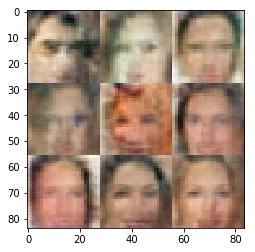

Epoch 3/20... Discriminator Loss: 1.3472... Generator Loss: 0.7380
Epoch 3/20... Discriminator Loss: 1.2189... Generator Loss: 0.6763
Epoch 3/20... Discriminator Loss: 0.7099... Generator Loss: 2.5799
Epoch 3/20... Discriminator Loss: 1.3697... Generator Loss: 0.5847
Epoch 3/20... Discriminator Loss: 1.3314... Generator Loss: 0.6705
Epoch 3/20... Discriminator Loss: 1.2001... Generator Loss: 0.6647
Epoch 3/20... Discriminator Loss: 1.2110... Generator Loss: 0.5143
Epoch 3/20... Discriminator Loss: 1.3886... Generator Loss: 0.4160
Epoch 3/20... Discriminator Loss: 1.2321... Generator Loss: 0.6832
Epoch 3/20... Discriminator Loss: 1.8224... Generator Loss: 2.4543
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


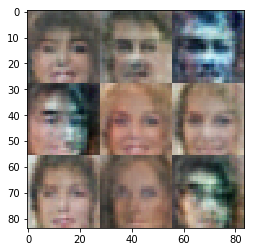

Epoch 3/20... Discriminator Loss: 1.2247... Generator Loss: 0.7798
Epoch 3/20... Discriminator Loss: 1.2950... Generator Loss: 1.0084
Epoch 3/20... Discriminator Loss: 1.0906... Generator Loss: 0.9465
Epoch 3/20... Discriminator Loss: 1.2050... Generator Loss: 0.4530
Epoch 3/20... Discriminator Loss: 1.3167... Generator Loss: 0.7294
Epoch 3/20... Discriminator Loss: 1.1481... Generator Loss: 0.8303
Epoch 3/20... Discriminator Loss: 1.2005... Generator Loss: 0.6109
Epoch 3/20... Discriminator Loss: 1.3284... Generator Loss: 0.5828
Epoch 3/20... Discriminator Loss: 1.3269... Generator Loss: 0.5122
Epoch 3/20... Discriminator Loss: 1.0542... Generator Loss: 0.6152
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


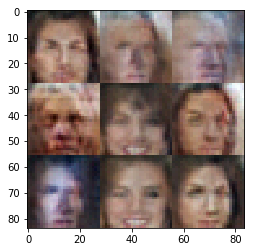

Epoch 3/20... Discriminator Loss: 1.5233... Generator Loss: 0.5214
Epoch 3/20... Discriminator Loss: 1.3329... Generator Loss: 0.6963
Epoch 3/20... Discriminator Loss: 1.3085... Generator Loss: 0.6487
Epoch 3/20... Discriminator Loss: 1.2637... Generator Loss: 0.6474
Time for previous epoch: 10204.889419794083
Time till previous epoch: 30889.341723918915
Epoch 4/20... Discriminator Loss: 1.3198... Generator Loss: 0.5381
Epoch 4/20... Discriminator Loss: 1.5369... Generator Loss: 1.6724
Epoch 4/20... Discriminator Loss: 1.3051... Generator Loss: 0.5948
Epoch 4/20... Discriminator Loss: 1.1889... Generator Loss: 0.6488
Epoch 4/20... Discriminator Loss: 1.3099... Generator Loss: 0.7471
Epoch 4/20... Discriminator Loss: 1.3724... Generator Loss: 0.7351
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


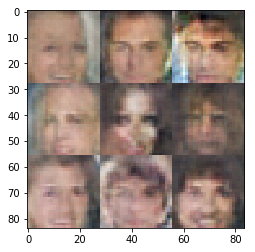

Epoch 4/20... Discriminator Loss: 1.1959... Generator Loss: 0.7237
Epoch 4/20... Discriminator Loss: 1.3333... Generator Loss: 0.6102
Epoch 4/20... Discriminator Loss: 1.4032... Generator Loss: 0.4847
Epoch 4/20... Discriminator Loss: 1.6098... Generator Loss: 0.3549
Epoch 4/20... Discriminator Loss: 1.2654... Generator Loss: 0.6944
Epoch 4/20... Discriminator Loss: 1.2841... Generator Loss: 0.6428
Epoch 4/20... Discriminator Loss: 1.5368... Generator Loss: 0.4058
Epoch 4/20... Discriminator Loss: 1.2690... Generator Loss: 0.6088
Epoch 4/20... Discriminator Loss: 1.2284... Generator Loss: 0.7059
Epoch 4/20... Discriminator Loss: 1.6528... Generator Loss: 0.3219
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


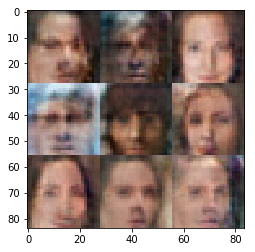

Epoch 4/20... Discriminator Loss: 1.3839... Generator Loss: 0.5442
Epoch 4/20... Discriminator Loss: 0.9475... Generator Loss: 0.8855
Epoch 4/20... Discriminator Loss: 1.4157... Generator Loss: 0.4705
Epoch 4/20... Discriminator Loss: 1.2973... Generator Loss: 0.7166
Epoch 4/20... Discriminator Loss: 1.3620... Generator Loss: 0.8562
Epoch 4/20... Discriminator Loss: 1.2967... Generator Loss: 0.8738
Epoch 4/20... Discriminator Loss: 1.2294... Generator Loss: 0.6410
Epoch 4/20... Discriminator Loss: 0.7628... Generator Loss: 3.1238
Epoch 4/20... Discriminator Loss: 1.2865... Generator Loss: 0.7342
Epoch 4/20... Discriminator Loss: 1.0641... Generator Loss: 0.7817
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


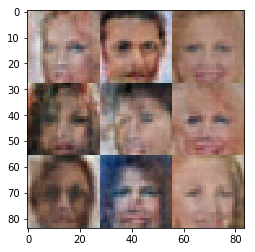

Epoch 4/20... Discriminator Loss: 1.4254... Generator Loss: 0.4999
Epoch 4/20... Discriminator Loss: 1.1660... Generator Loss: 0.6965
Epoch 4/20... Discriminator Loss: 1.1797... Generator Loss: 0.7274
Epoch 4/20... Discriminator Loss: 1.3864... Generator Loss: 0.8494
Epoch 4/20... Discriminator Loss: 1.4454... Generator Loss: 0.4349
Epoch 4/20... Discriminator Loss: 1.3706... Generator Loss: 0.7061
Epoch 4/20... Discriminator Loss: 1.4219... Generator Loss: 0.4000
Epoch 4/20... Discriminator Loss: 1.2304... Generator Loss: 0.5632
Epoch 4/20... Discriminator Loss: 1.3439... Generator Loss: 0.7665
Epoch 4/20... Discriminator Loss: 1.6261... Generator Loss: 0.3124
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


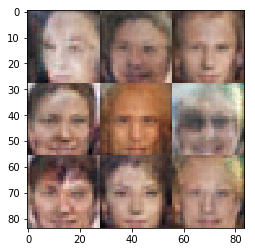

Epoch 4/20... Discriminator Loss: 1.7028... Generator Loss: 0.2591
Epoch 4/20... Discriminator Loss: 1.5019... Generator Loss: 0.4063
Epoch 4/20... Discriminator Loss: 1.2169... Generator Loss: 0.6369
Epoch 4/20... Discriminator Loss: 1.2173... Generator Loss: 0.9178
Epoch 4/20... Discriminator Loss: 1.4198... Generator Loss: 0.5696
Epoch 4/20... Discriminator Loss: 1.5421... Generator Loss: 0.3963
Epoch 4/20... Discriminator Loss: 1.2122... Generator Loss: 0.7245
Epoch 4/20... Discriminator Loss: 1.5061... Generator Loss: 0.5763
Epoch 4/20... Discriminator Loss: 1.3270... Generator Loss: 0.6282
Epoch 4/20... Discriminator Loss: 0.6425... Generator Loss: 2.0304
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


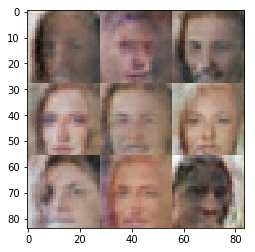

Epoch 4/20... Discriminator Loss: 1.4583... Generator Loss: 0.4889
Epoch 4/20... Discriminator Loss: 1.3050... Generator Loss: 0.7243
Epoch 4/20... Discriminator Loss: 1.3619... Generator Loss: 0.6786
Epoch 4/20... Discriminator Loss: 1.4888... Generator Loss: 1.4825
Epoch 4/20... Discriminator Loss: 1.3464... Generator Loss: 0.6022
Epoch 4/20... Discriminator Loss: 1.4639... Generator Loss: 0.4356
Epoch 4/20... Discriminator Loss: 1.3773... Generator Loss: 0.5422
Epoch 4/20... Discriminator Loss: 1.3802... Generator Loss: 0.7821
Epoch 4/20... Discriminator Loss: 1.4698... Generator Loss: 0.4256
Epoch 4/20... Discriminator Loss: 1.3613... Generator Loss: 0.5753
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


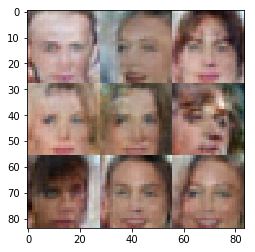

Epoch 4/20... Discriminator Loss: 1.3971... Generator Loss: 0.5411
Epoch 4/20... Discriminator Loss: 1.2318... Generator Loss: 0.7544
Epoch 4/20... Discriminator Loss: 1.2738... Generator Loss: 0.5541
Epoch 4/20... Discriminator Loss: 1.2442... Generator Loss: 0.6860
Epoch 4/20... Discriminator Loss: 1.4462... Generator Loss: 0.5427
Epoch 4/20... Discriminator Loss: 1.3408... Generator Loss: 0.5397
Epoch 4/20... Discriminator Loss: 1.2637... Generator Loss: 0.8398
Epoch 4/20... Discriminator Loss: 1.3125... Generator Loss: 0.5483
Epoch 4/20... Discriminator Loss: 1.2840... Generator Loss: 0.8615
Epoch 4/20... Discriminator Loss: 2.4408... Generator Loss: 0.1117
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


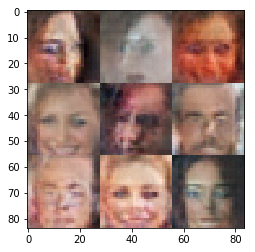

Epoch 4/20... Discriminator Loss: 1.4349... Generator Loss: 0.5067
Epoch 4/20... Discriminator Loss: 1.3619... Generator Loss: 0.5608
Epoch 4/20... Discriminator Loss: 1.1955... Generator Loss: 0.7079
Epoch 4/20... Discriminator Loss: 1.5872... Generator Loss: 1.8744
Epoch 4/20... Discriminator Loss: 1.3566... Generator Loss: 0.8069
Epoch 4/20... Discriminator Loss: 1.2797... Generator Loss: 0.6354
Epoch 4/20... Discriminator Loss: 1.4755... Generator Loss: 0.5187
Epoch 4/20... Discriminator Loss: 1.3598... Generator Loss: 0.5486
Epoch 4/20... Discriminator Loss: 1.4583... Generator Loss: 0.6715
Epoch 4/20... Discriminator Loss: 1.2345... Generator Loss: 0.7437
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


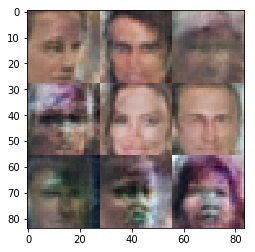

Epoch 4/20... Discriminator Loss: 1.4051... Generator Loss: 0.5056
Epoch 4/20... Discriminator Loss: 1.3214... Generator Loss: 0.6736
Epoch 4/20... Discriminator Loss: 1.7913... Generator Loss: 0.2432
Epoch 4/20... Discriminator Loss: 1.4694... Generator Loss: 0.5187
Epoch 4/20... Discriminator Loss: 1.3654... Generator Loss: 0.5183
Epoch 4/20... Discriminator Loss: 1.3391... Generator Loss: 0.5866
Epoch 4/20... Discriminator Loss: 1.4064... Generator Loss: 0.4877
Epoch 4/20... Discriminator Loss: 1.3566... Generator Loss: 0.6859
Epoch 4/20... Discriminator Loss: 1.4694... Generator Loss: 0.5627
Epoch 4/20... Discriminator Loss: 1.3820... Generator Loss: 0.4854
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


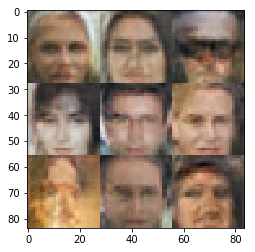

Epoch 4/20... Discriminator Loss: 1.3240... Generator Loss: 0.6818
Epoch 4/20... Discriminator Loss: 1.3019... Generator Loss: 0.5620
Epoch 4/20... Discriminator Loss: 1.4258... Generator Loss: 0.5708
Epoch 4/20... Discriminator Loss: 1.3259... Generator Loss: 0.6118
Epoch 4/20... Discriminator Loss: 1.3874... Generator Loss: 0.6400
Epoch 4/20... Discriminator Loss: 1.2806... Generator Loss: 1.0669
Epoch 4/20... Discriminator Loss: 1.2443... Generator Loss: 0.5121
Epoch 4/20... Discriminator Loss: 1.4816... Generator Loss: 0.5690
Epoch 4/20... Discriminator Loss: 1.3751... Generator Loss: 0.5755
Epoch 4/20... Discriminator Loss: 1.7396... Generator Loss: 0.2451
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


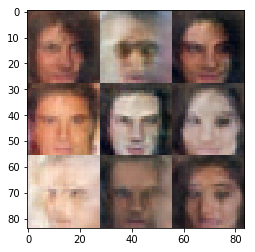

Epoch 4/20... Discriminator Loss: 1.3758... Generator Loss: 0.6512
Epoch 4/20... Discriminator Loss: 1.3622... Generator Loss: 0.5921
Epoch 4/20... Discriminator Loss: 1.2037... Generator Loss: 0.7661
Epoch 4/20... Discriminator Loss: 1.4665... Generator Loss: 0.4684
Epoch 4/20... Discriminator Loss: 1.3999... Generator Loss: 0.4716
Epoch 4/20... Discriminator Loss: 1.3678... Generator Loss: 0.5460
Epoch 4/20... Discriminator Loss: 1.4647... Generator Loss: 0.4115
Epoch 4/20... Discriminator Loss: 1.4776... Generator Loss: 0.6586
Epoch 4/20... Discriminator Loss: 1.3646... Generator Loss: 0.5452
Epoch 4/20... Discriminator Loss: 1.3514... Generator Loss: 0.7141
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


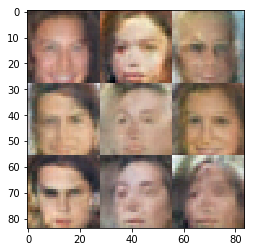

Epoch 4/20... Discriminator Loss: 1.3680... Generator Loss: 0.5347
Epoch 4/20... Discriminator Loss: 1.3219... Generator Loss: 0.4952
Epoch 4/20... Discriminator Loss: 1.4383... Generator Loss: 0.4451
Epoch 4/20... Discriminator Loss: 1.3214... Generator Loss: 0.7073
Epoch 4/20... Discriminator Loss: 1.3977... Generator Loss: 0.8363
Epoch 4/20... Discriminator Loss: 1.4365... Generator Loss: 0.5076
Epoch 4/20... Discriminator Loss: 1.3467... Generator Loss: 0.6109
Epoch 4/20... Discriminator Loss: 1.3537... Generator Loss: 0.7070
Epoch 4/20... Discriminator Loss: 1.4073... Generator Loss: 0.5848
Epoch 4/20... Discriminator Loss: 1.3223... Generator Loss: 0.7401
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


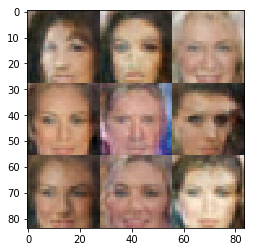

Epoch 4/20... Discriminator Loss: 1.4500... Generator Loss: 0.5500
Epoch 4/20... Discriminator Loss: 1.4974... Generator Loss: 0.4396
Epoch 4/20... Discriminator Loss: 1.5016... Generator Loss: 0.5085
Epoch 4/20... Discriminator Loss: 1.3529... Generator Loss: 0.7008
Epoch 4/20... Discriminator Loss: 1.4432... Generator Loss: 0.4028
Epoch 4/20... Discriminator Loss: 1.3340... Generator Loss: 0.6032
Epoch 4/20... Discriminator Loss: 1.3589... Generator Loss: 0.5574
Epoch 4/20... Discriminator Loss: 1.4181... Generator Loss: 0.6605
Epoch 4/20... Discriminator Loss: 1.4243... Generator Loss: 0.4447
Epoch 4/20... Discriminator Loss: 1.4100... Generator Loss: 0.5822
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


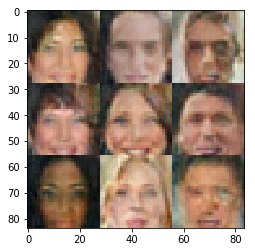

Epoch 4/20... Discriminator Loss: 1.4099... Generator Loss: 0.6066
Epoch 4/20... Discriminator Loss: 1.4229... Generator Loss: 0.5744
Epoch 4/20... Discriminator Loss: 1.3202... Generator Loss: 0.6845
Epoch 4/20... Discriminator Loss: 1.3847... Generator Loss: 0.5013
Epoch 4/20... Discriminator Loss: 1.2542... Generator Loss: 0.6796
Epoch 4/20... Discriminator Loss: 1.1769... Generator Loss: 0.6040
Epoch 4/20... Discriminator Loss: 1.2321... Generator Loss: 0.8091
Epoch 4/20... Discriminator Loss: 1.3241... Generator Loss: 0.6591
Epoch 4/20... Discriminator Loss: 1.4892... Generator Loss: 0.5333
Epoch 4/20... Discriminator Loss: 1.3583... Generator Loss: 0.5710
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


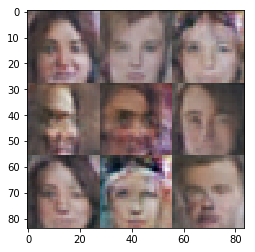

Epoch 4/20... Discriminator Loss: 1.7341... Generator Loss: 0.2483
Epoch 4/20... Discriminator Loss: 1.4834... Generator Loss: 0.4494
Epoch 4/20... Discriminator Loss: 1.3717... Generator Loss: 0.5674
Epoch 4/20... Discriminator Loss: 1.5086... Generator Loss: 0.3994
Epoch 4/20... Discriminator Loss: 1.3539... Generator Loss: 0.5815
Epoch 4/20... Discriminator Loss: 1.5114... Generator Loss: 0.5714
Epoch 4/20... Discriminator Loss: 1.3873... Generator Loss: 0.5214
Epoch 4/20... Discriminator Loss: 1.3914... Generator Loss: 0.5209
Epoch 4/20... Discriminator Loss: 1.4048... Generator Loss: 0.5864
Epoch 4/20... Discriminator Loss: 1.4503... Generator Loss: 0.5726
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


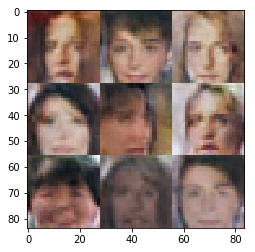

Epoch 4/20... Discriminator Loss: 1.4769... Generator Loss: 0.6627
Epoch 4/20... Discriminator Loss: 1.3673... Generator Loss: 0.5916
Epoch 4/20... Discriminator Loss: 1.3251... Generator Loss: 0.6252
Epoch 4/20... Discriminator Loss: 1.5342... Generator Loss: 0.4067
Epoch 4/20... Discriminator Loss: 1.4218... Generator Loss: 0.6254
Epoch 4/20... Discriminator Loss: 1.3887... Generator Loss: 0.5972
Epoch 4/20... Discriminator Loss: 1.3454... Generator Loss: 0.5384
Epoch 4/20... Discriminator Loss: 1.5143... Generator Loss: 0.4468
Epoch 4/20... Discriminator Loss: 1.3674... Generator Loss: 0.4685
Epoch 4/20... Discriminator Loss: 1.4285... Generator Loss: 0.5746
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


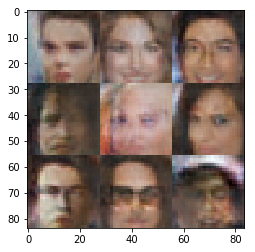

Epoch 4/20... Discriminator Loss: 1.1894... Generator Loss: 0.6971
Epoch 4/20... Discriminator Loss: 1.3895... Generator Loss: 0.5768
Time for previous epoch: 10401.286052703857
Time till previous epoch: 41290.63577747345
Epoch 5/20... Discriminator Loss: 1.2272... Generator Loss: 0.7642
Epoch 5/20... Discriminator Loss: 1.4081... Generator Loss: 0.7707
Epoch 5/20... Discriminator Loss: 1.2898... Generator Loss: 0.6924
Epoch 5/20... Discriminator Loss: 1.2590... Generator Loss: 0.6214
Epoch 5/20... Discriminator Loss: 1.3882... Generator Loss: 0.5549
Epoch 5/20... Discriminator Loss: 1.4580... Generator Loss: 0.6123
Epoch 5/20... Discriminator Loss: 1.3737... Generator Loss: 0.6390
Epoch 5/20... Discriminator Loss: 1.3224... Generator Loss: 0.6717
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


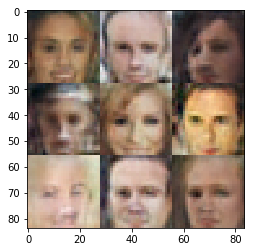

Epoch 5/20... Discriminator Loss: 1.3147... Generator Loss: 0.5848
Epoch 5/20... Discriminator Loss: 1.5182... Generator Loss: 0.4325
Epoch 5/20... Discriminator Loss: 1.5793... Generator Loss: 0.3725
Epoch 5/20... Discriminator Loss: 1.4281... Generator Loss: 0.4612
Epoch 5/20... Discriminator Loss: 1.4216... Generator Loss: 0.8177
Epoch 5/20... Discriminator Loss: 1.4533... Generator Loss: 0.5371
Epoch 5/20... Discriminator Loss: 1.3756... Generator Loss: 0.5993
Epoch 5/20... Discriminator Loss: 1.6609... Generator Loss: 0.3241
Epoch 5/20... Discriminator Loss: 1.5414... Generator Loss: 0.4867
Epoch 5/20... Discriminator Loss: 1.4699... Generator Loss: 0.5314
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


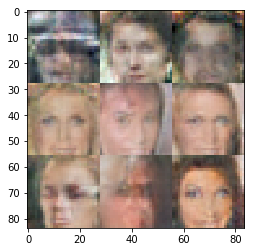

Epoch 5/20... Discriminator Loss: 1.5452... Generator Loss: 0.4766
Epoch 5/20... Discriminator Loss: 1.3388... Generator Loss: 0.6554
Epoch 5/20... Discriminator Loss: 1.4706... Generator Loss: 0.5281
Epoch 5/20... Discriminator Loss: 1.3056... Generator Loss: 0.6977
Epoch 5/20... Discriminator Loss: 1.6457... Generator Loss: 0.3410
Epoch 5/20... Discriminator Loss: 1.3540... Generator Loss: 0.7140
Epoch 5/20... Discriminator Loss: 1.5209... Generator Loss: 0.5328
Epoch 5/20... Discriminator Loss: 1.3869... Generator Loss: 0.6707
Epoch 5/20... Discriminator Loss: 1.4627... Generator Loss: 0.4806
Epoch 5/20... Discriminator Loss: 1.5589... Generator Loss: 0.4845
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


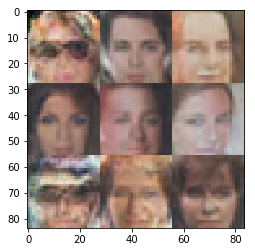

Epoch 5/20... Discriminator Loss: 1.4451... Generator Loss: 0.6239
Epoch 5/20... Discriminator Loss: 1.5303... Generator Loss: 0.4705
Epoch 5/20... Discriminator Loss: 1.4728... Generator Loss: 0.6290
Epoch 5/20... Discriminator Loss: 1.3357... Generator Loss: 0.6149
Epoch 5/20... Discriminator Loss: 1.4430... Generator Loss: 0.5691
Epoch 5/20... Discriminator Loss: 1.4015... Generator Loss: 0.6762
Epoch 5/20... Discriminator Loss: 1.5470... Generator Loss: 0.6426
Epoch 5/20... Discriminator Loss: 0.7066... Generator Loss: 1.6608
Epoch 5/20... Discriminator Loss: 1.3057... Generator Loss: 0.6921
Epoch 5/20... Discriminator Loss: 1.4076... Generator Loss: 0.5793
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


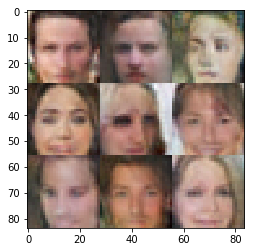

Epoch 5/20... Discriminator Loss: 1.4220... Generator Loss: 0.4820
Epoch 5/20... Discriminator Loss: 1.3100... Generator Loss: 0.6698
Epoch 5/20... Discriminator Loss: 1.3089... Generator Loss: 0.5786
Epoch 5/20... Discriminator Loss: 1.4780... Generator Loss: 0.5518
Epoch 5/20... Discriminator Loss: 1.6027... Generator Loss: 0.4410
Epoch 5/20... Discriminator Loss: 1.5411... Generator Loss: 0.3971
Epoch 5/20... Discriminator Loss: 1.4442... Generator Loss: 0.4355
Epoch 5/20... Discriminator Loss: 1.1129... Generator Loss: 0.6750
Epoch 5/20... Discriminator Loss: 1.4026... Generator Loss: 1.0479
Epoch 5/20... Discriminator Loss: 1.3317... Generator Loss: 0.6210
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


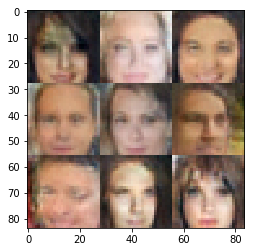

Epoch 5/20... Discriminator Loss: 1.3309... Generator Loss: 0.7334
Epoch 5/20... Discriminator Loss: 1.4618... Generator Loss: 0.4593
Epoch 5/20... Discriminator Loss: 1.3594... Generator Loss: 0.5901
Epoch 5/20... Discriminator Loss: 1.5088... Generator Loss: 0.4752
Epoch 5/20... Discriminator Loss: 1.4515... Generator Loss: 0.4996
Epoch 5/20... Discriminator Loss: 1.4202... Generator Loss: 0.6144
Epoch 5/20... Discriminator Loss: 1.4476... Generator Loss: 0.5760
Epoch 5/20... Discriminator Loss: 1.5314... Generator Loss: 0.5287
Epoch 5/20... Discriminator Loss: 1.2542... Generator Loss: 0.6359
Epoch 5/20... Discriminator Loss: 1.3082... Generator Loss: 0.8257
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


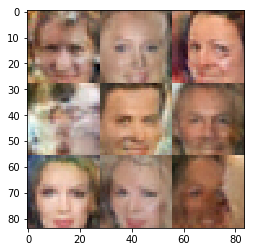

Epoch 5/20... Discriminator Loss: 1.3060... Generator Loss: 0.5812
Epoch 5/20... Discriminator Loss: 1.4245... Generator Loss: 0.4971
Epoch 5/20... Discriminator Loss: 1.6113... Generator Loss: 0.6278
Epoch 5/20... Discriminator Loss: 1.5094... Generator Loss: 0.5385
Epoch 5/20... Discriminator Loss: 1.6681... Generator Loss: 0.3127
Epoch 5/20... Discriminator Loss: 0.5377... Generator Loss: 2.8715
Epoch 5/20... Discriminator Loss: 3.2193... Generator Loss: 0.0455
Epoch 5/20... Discriminator Loss: 1.4740... Generator Loss: 0.4872
Epoch 5/20... Discriminator Loss: 1.4905... Generator Loss: 0.5769
Epoch 5/20... Discriminator Loss: 1.4656... Generator Loss: 0.5182
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


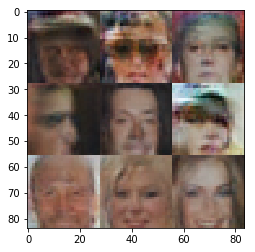

Epoch 5/20... Discriminator Loss: 1.5916... Generator Loss: 0.3931
Epoch 5/20... Discriminator Loss: 1.3750... Generator Loss: 0.5730
Epoch 5/20... Discriminator Loss: 1.3608... Generator Loss: 0.5333
Epoch 5/20... Discriminator Loss: 1.4487... Generator Loss: 0.4663
Epoch 5/20... Discriminator Loss: 1.4376... Generator Loss: 0.5218
Epoch 5/20... Discriminator Loss: 1.4619... Generator Loss: 0.5307
Epoch 5/20... Discriminator Loss: 1.4982... Generator Loss: 0.4894
Epoch 5/20... Discriminator Loss: 1.6966... Generator Loss: 0.3762
Epoch 5/20... Discriminator Loss: 1.5297... Generator Loss: 0.4641
Epoch 5/20... Discriminator Loss: 1.3271... Generator Loss: 0.6012
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


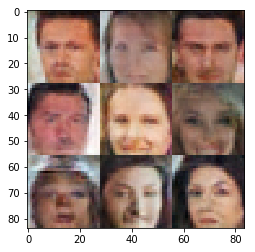

Epoch 5/20... Discriminator Loss: 1.4808... Generator Loss: 0.4358
Epoch 5/20... Discriminator Loss: 1.3105... Generator Loss: 0.7142
Epoch 5/20... Discriminator Loss: 1.5128... Generator Loss: 0.4860
Epoch 5/20... Discriminator Loss: 1.6272... Generator Loss: 0.3987
Epoch 5/20... Discriminator Loss: 1.2964... Generator Loss: 0.6452
Epoch 5/20... Discriminator Loss: 1.4031... Generator Loss: 0.4618
Epoch 5/20... Discriminator Loss: 1.5717... Generator Loss: 0.3904
Epoch 5/20... Discriminator Loss: 1.5594... Generator Loss: 0.3950
Epoch 5/20... Discriminator Loss: 1.5585... Generator Loss: 0.4981
Epoch 5/20... Discriminator Loss: 1.4116... Generator Loss: 0.5542
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


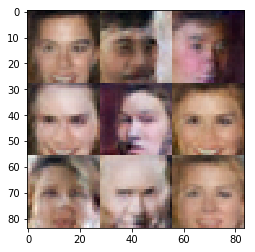

Epoch 5/20... Discriminator Loss: 1.4636... Generator Loss: 0.4530
Epoch 5/20... Discriminator Loss: 1.3301... Generator Loss: 0.6382
Epoch 5/20... Discriminator Loss: 1.4781... Generator Loss: 0.6579
Epoch 5/20... Discriminator Loss: 1.5492... Generator Loss: 0.4386
Epoch 5/20... Discriminator Loss: 1.5550... Generator Loss: 0.4609
Epoch 5/20... Discriminator Loss: 1.5438... Generator Loss: 0.3803
Epoch 5/20... Discriminator Loss: 1.3069... Generator Loss: 0.6923
Epoch 5/20... Discriminator Loss: 1.4534... Generator Loss: 0.6586
Epoch 5/20... Discriminator Loss: 1.4128... Generator Loss: 0.7057
Epoch 5/20... Discriminator Loss: 1.4557... Generator Loss: 0.4705
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


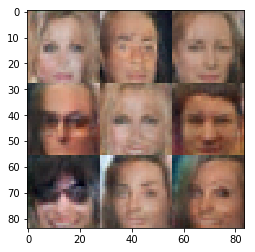

Epoch 5/20... Discriminator Loss: 1.4116... Generator Loss: 0.6787
Epoch 5/20... Discriminator Loss: 1.4774... Generator Loss: 0.5531
Epoch 5/20... Discriminator Loss: 1.3605... Generator Loss: 0.6351
Epoch 5/20... Discriminator Loss: 2.4235... Generator Loss: 0.1182
Epoch 5/20... Discriminator Loss: 1.4572... Generator Loss: 0.7678
Epoch 5/20... Discriminator Loss: 0.8709... Generator Loss: 1.0189
Epoch 5/20... Discriminator Loss: 1.4599... Generator Loss: 0.5035
Epoch 5/20... Discriminator Loss: 1.5601... Generator Loss: 0.3939
Epoch 5/20... Discriminator Loss: 1.4745... Generator Loss: 0.4840
Epoch 5/20... Discriminator Loss: 1.5053... Generator Loss: 0.5726
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


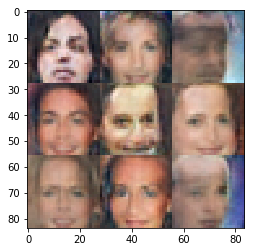

Epoch 5/20... Discriminator Loss: 1.4111... Generator Loss: 0.7145
Epoch 5/20... Discriminator Loss: 1.5354... Generator Loss: 0.4121
Epoch 5/20... Discriminator Loss: 1.6352... Generator Loss: 0.8176
Epoch 5/20... Discriminator Loss: 1.3431... Generator Loss: 0.5875
Epoch 5/20... Discriminator Loss: 1.4444... Generator Loss: 0.5161
Epoch 5/20... Discriminator Loss: 1.3736... Generator Loss: 0.5194
Epoch 5/20... Discriminator Loss: 1.5093... Generator Loss: 0.4923
Epoch 5/20... Discriminator Loss: 1.4912... Generator Loss: 0.6918
Epoch 5/20... Discriminator Loss: 1.4099... Generator Loss: 0.4297
Epoch 5/20... Discriminator Loss: 1.4328... Generator Loss: 0.6059
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


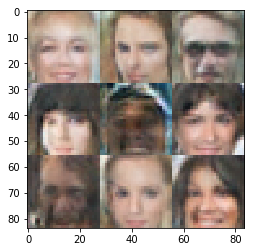

Epoch 5/20... Discriminator Loss: 1.3223... Generator Loss: 0.5865
Epoch 5/20... Discriminator Loss: 1.3159... Generator Loss: 0.5691
Epoch 5/20... Discriminator Loss: 1.5266... Generator Loss: 0.4944
Epoch 5/20... Discriminator Loss: 1.4819... Generator Loss: 0.5369
Epoch 5/20... Discriminator Loss: 1.5902... Generator Loss: 0.5841
Epoch 5/20... Discriminator Loss: 1.2928... Generator Loss: 0.6953
Epoch 5/20... Discriminator Loss: 1.3928... Generator Loss: 0.6355
Epoch 5/20... Discriminator Loss: 1.5558... Generator Loss: 0.5879
Epoch 5/20... Discriminator Loss: 1.3006... Generator Loss: 0.6498
Epoch 5/20... Discriminator Loss: 1.4814... Generator Loss: 0.8519
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


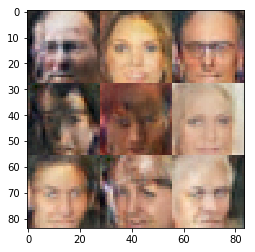

Epoch 5/20... Discriminator Loss: 1.5399... Generator Loss: 0.4357
Epoch 5/20... Discriminator Loss: 1.5045... Generator Loss: 0.5130
Epoch 5/20... Discriminator Loss: 1.4549... Generator Loss: 0.5512
Epoch 5/20... Discriminator Loss: 1.5345... Generator Loss: 0.4658
Epoch 5/20... Discriminator Loss: 1.4367... Generator Loss: 0.5426
Epoch 5/20... Discriminator Loss: 1.5701... Generator Loss: 0.3721
Epoch 5/20... Discriminator Loss: 1.6737... Generator Loss: 0.3312
Epoch 5/20... Discriminator Loss: 1.4937... Generator Loss: 0.6180
Epoch 5/20... Discriminator Loss: 1.5214... Generator Loss: 0.5216
Epoch 5/20... Discriminator Loss: 1.4890... Generator Loss: 0.5373
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


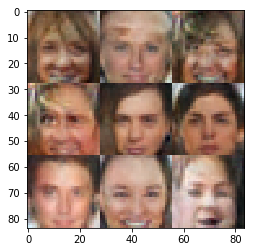

Epoch 5/20... Discriminator Loss: 1.4504... Generator Loss: 0.4809
Epoch 5/20... Discriminator Loss: 1.4653... Generator Loss: 0.6232
Epoch 5/20... Discriminator Loss: 1.4076... Generator Loss: 0.5320
Epoch 5/20... Discriminator Loss: 1.6153... Generator Loss: 0.3820
Epoch 5/20... Discriminator Loss: 1.4561... Generator Loss: 0.5994
Epoch 5/20... Discriminator Loss: 1.4652... Generator Loss: 0.4705
Epoch 5/20... Discriminator Loss: 1.4297... Generator Loss: 0.5903
Epoch 5/20... Discriminator Loss: 1.5951... Generator Loss: 0.7245
Epoch 5/20... Discriminator Loss: 1.3454... Generator Loss: 0.6245
Epoch 5/20... Discriminator Loss: 1.5474... Generator Loss: 0.4812
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


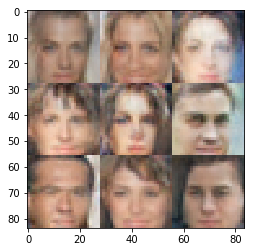

Epoch 5/20... Discriminator Loss: 1.4285... Generator Loss: 0.4358
Epoch 5/20... Discriminator Loss: 1.7262... Generator Loss: 0.2814
Epoch 5/20... Discriminator Loss: 1.7115... Generator Loss: 0.3621
Epoch 5/20... Discriminator Loss: 1.5009... Generator Loss: 0.4708
Epoch 5/20... Discriminator Loss: 1.2874... Generator Loss: 0.5983
Epoch 5/20... Discriminator Loss: 1.4872... Generator Loss: 0.4717
Epoch 5/20... Discriminator Loss: 1.5430... Generator Loss: 0.5056
Epoch 5/20... Discriminator Loss: 1.5018... Generator Loss: 0.7082
Epoch 5/20... Discriminator Loss: 1.3991... Generator Loss: 0.5692
Epoch 5/20... Discriminator Loss: 1.5498... Generator Loss: 0.3941
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


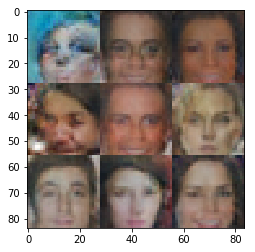

Epoch 5/20... Discriminator Loss: 1.5102... Generator Loss: 0.5686
Time for previous epoch: 10335.170176744461
Time till previous epoch: 51625.81495523453
Epoch 6/20... Discriminator Loss: 1.7143... Generator Loss: 0.3746
Epoch 6/20... Discriminator Loss: 1.5510... Generator Loss: 0.5425
Epoch 6/20... Discriminator Loss: 1.5440... Generator Loss: 0.5532
Epoch 6/20... Discriminator Loss: 1.5422... Generator Loss: 0.4522
Epoch 6/20... Discriminator Loss: 1.2099... Generator Loss: 0.7686
Epoch 6/20... Discriminator Loss: 1.6359... Generator Loss: 0.3621
Epoch 6/20... Discriminator Loss: 1.5777... Generator Loss: 0.3891
Epoch 6/20... Discriminator Loss: 1.3859... Generator Loss: 0.8203
Epoch 6/20... Discriminator Loss: 1.6206... Generator Loss: 0.3649
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


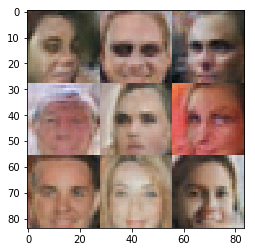

Epoch 6/20... Discriminator Loss: 1.3192... Generator Loss: 0.4579
Epoch 6/20... Discriminator Loss: 1.4596... Generator Loss: 0.5442
Epoch 6/20... Discriminator Loss: 1.5816... Generator Loss: 0.4779
Epoch 6/20... Discriminator Loss: 1.3879... Generator Loss: 0.7382
Epoch 6/20... Discriminator Loss: 1.3017... Generator Loss: 0.5907
Epoch 6/20... Discriminator Loss: 0.5221... Generator Loss: 2.9374
Epoch 6/20... Discriminator Loss: 1.4247... Generator Loss: 0.4904
Epoch 6/20... Discriminator Loss: 1.5040... Generator Loss: 0.3851
Epoch 6/20... Discriminator Loss: 1.3258... Generator Loss: 1.6575
Epoch 6/20... Discriminator Loss: 1.3986... Generator Loss: 0.4556
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


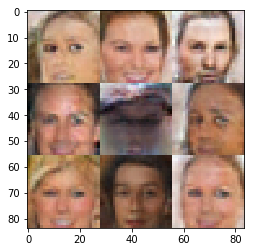

Epoch 6/20... Discriminator Loss: 1.5092... Generator Loss: 0.4584
Epoch 6/20... Discriminator Loss: 1.4757... Generator Loss: 0.4435
Epoch 6/20... Discriminator Loss: 1.5121... Generator Loss: 0.5720
Epoch 6/20... Discriminator Loss: 1.4616... Generator Loss: 0.4730
Epoch 6/20... Discriminator Loss: 1.3811... Generator Loss: 0.6106
Epoch 6/20... Discriminator Loss: 1.4069... Generator Loss: 0.5612
Epoch 6/20... Discriminator Loss: 1.6075... Generator Loss: 0.3786
Epoch 6/20... Discriminator Loss: 1.3969... Generator Loss: 0.4990
Epoch 6/20... Discriminator Loss: 1.3940... Generator Loss: 0.7148
Epoch 6/20... Discriminator Loss: 1.3903... Generator Loss: 0.6885
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


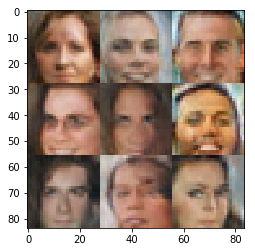

Epoch 6/20... Discriminator Loss: 1.4312... Generator Loss: 0.4379
Epoch 6/20... Discriminator Loss: 1.5673... Generator Loss: 0.3938
Epoch 6/20... Discriminator Loss: 1.5069... Generator Loss: 0.5337
Epoch 6/20... Discriminator Loss: 1.4078... Generator Loss: 0.5170
Epoch 6/20... Discriminator Loss: 1.4962... Generator Loss: 0.5992
Epoch 6/20... Discriminator Loss: 1.4852... Generator Loss: 0.4750
Epoch 6/20... Discriminator Loss: 1.4808... Generator Loss: 0.4830
Epoch 6/20... Discriminator Loss: 1.5466... Generator Loss: 0.4149
Epoch 6/20... Discriminator Loss: 1.2851... Generator Loss: 0.8250
Epoch 6/20... Discriminator Loss: 1.6017... Generator Loss: 0.4414
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


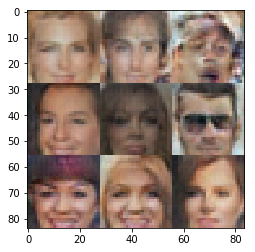

Epoch 6/20... Discriminator Loss: 1.3882... Generator Loss: 1.1872
Epoch 6/20... Discriminator Loss: 1.5094... Generator Loss: 0.5434
Epoch 6/20... Discriminator Loss: 1.5718... Generator Loss: 0.3700
Epoch 6/20... Discriminator Loss: 1.3609... Generator Loss: 0.5638
Epoch 6/20... Discriminator Loss: 1.6455... Generator Loss: 0.3483
Epoch 6/20... Discriminator Loss: 1.3622... Generator Loss: 0.5520
Epoch 6/20... Discriminator Loss: 1.3956... Generator Loss: 0.4979
Epoch 6/20... Discriminator Loss: 1.4286... Generator Loss: 0.5093
Epoch 6/20... Discriminator Loss: 1.6028... Generator Loss: 0.4348
Epoch 6/20... Discriminator Loss: 1.6994... Generator Loss: 0.4946
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


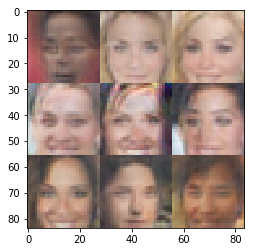

Epoch 6/20... Discriminator Loss: 1.5078... Generator Loss: 0.5654
Epoch 6/20... Discriminator Loss: 1.3952... Generator Loss: 0.6238
Epoch 6/20... Discriminator Loss: 1.5794... Generator Loss: 0.6935
Epoch 6/20... Discriminator Loss: 1.7977... Generator Loss: 0.3055
Epoch 6/20... Discriminator Loss: 1.3600... Generator Loss: 0.6916
Epoch 6/20... Discriminator Loss: 1.4515... Generator Loss: 0.5425
Epoch 6/20... Discriminator Loss: 1.5358... Generator Loss: 0.4744
Epoch 6/20... Discriminator Loss: 1.4568... Generator Loss: 0.4613
Epoch 6/20... Discriminator Loss: 1.4383... Generator Loss: 0.6056
Epoch 6/20... Discriminator Loss: 1.5690... Generator Loss: 0.4051
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


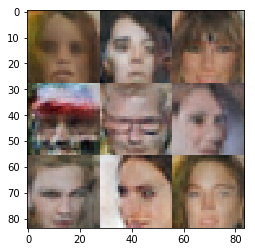

Epoch 6/20... Discriminator Loss: 1.9797... Generator Loss: 0.3404
Epoch 6/20... Discriminator Loss: 1.4924... Generator Loss: 0.4783
Epoch 6/20... Discriminator Loss: 1.4348... Generator Loss: 0.4568
Epoch 6/20... Discriminator Loss: 1.6608... Generator Loss: 0.3833
Epoch 6/20... Discriminator Loss: 1.3805... Generator Loss: 0.6285
Epoch 6/20... Discriminator Loss: 1.7879... Generator Loss: 0.3830
Epoch 6/20... Discriminator Loss: 1.4931... Generator Loss: 0.4546
Epoch 6/20... Discriminator Loss: 1.6229... Generator Loss: 0.3439
Epoch 6/20... Discriminator Loss: 1.5296... Generator Loss: 0.3645
Epoch 6/20... Discriminator Loss: 1.6957... Generator Loss: 0.3923
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


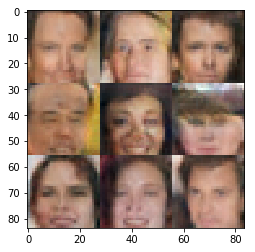

Epoch 6/20... Discriminator Loss: 1.4358... Generator Loss: 0.5126
Epoch 6/20... Discriminator Loss: 1.4665... Generator Loss: 0.5203
Epoch 6/20... Discriminator Loss: 1.6899... Generator Loss: 0.4123
Epoch 6/20... Discriminator Loss: 1.5747... Generator Loss: 0.3829
Epoch 6/20... Discriminator Loss: 1.5070... Generator Loss: 0.4039
Epoch 6/20... Discriminator Loss: 1.4602... Generator Loss: 0.3911
Epoch 6/20... Discriminator Loss: 1.4513... Generator Loss: 0.4382
Epoch 6/20... Discriminator Loss: 1.3459... Generator Loss: 0.6354
Epoch 6/20... Discriminator Loss: 1.6772... Generator Loss: 0.4136
Epoch 6/20... Discriminator Loss: 1.4273... Generator Loss: 0.4973
(?, 3, 3, 1024)
(?, 7, 7, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 14, 14, 64)
(?, 28, 28, 3)


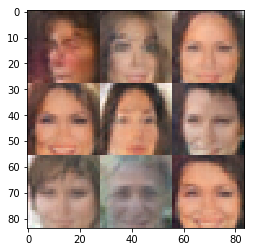

KeyboardInterrupt: 

In [73]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 20    #trained till 6 epochs

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.